#Team Project - Causal Discovery

##The aim of this project is to use convergence cross mapping to discover causal relationships that popular algorithms like Granger find difficulties to discover. To achieve this, we follow the below steps.



*   Generate synthetic dataset and test and evaluate both baseline algorithms and CCM algorithm
*   Use these tested algorithms on our real world data
*   List item
*   List item
*   List item
*   List item

We will like to mention that 80% of the content in this project is knowledge gained from class while 20% is taken from external resources.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install jdc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import jdc # used fo defining functions for a class in separate cells
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
from scipy.interpolate import make_interp_spline
from tqdm import tqdm # for showing progress bar in for loops
from scipy.stats import pearsonr
from random import randrange
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf, grangercausalitytests
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
%matplotlib inline

from random import randrange
from pandas import Series
from matplotlib import pyplot


### Just to remove warnings to prettify the notebook. 
import warnings
warnings.filterwarnings("ignore")


from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
from scipy import optimize
import statsmodels.api as sm # check the error that cannot import name 'factorial' in from scipy.misc import factorial
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import tensorflow as tf
import altair as alt

!pip install tensorflow==2.0.0-alpha0
!pip install linearmodels
from linearmodels.iv import IV2SLS
from tensorflow.keras import datasets, layers, models
from tensorflow import keras


from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
!pip install graphviz
!apt install libgraphviz-dev
!pip install pygraphviz
!pip install zepid
from zepid.causal.causalgraph import DirectedAcyclicGraph

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
import pygraphviz as pgv

import seaborn as sns
!pip install causal-learn
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import kci, chisq, fisherz
from causallearn.search.ScoreBased.GES import ges
from causallearn.utils.GESUtils import local_score_BIC
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

!pip install causalgraphicalmodels
from causalgraphicalmodels import CausalGraphicalModel
from causalgraphicalmodels.examples import fork, chain, collider

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tensorflow==2.0.0-alpha0 (from versions: 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.4.4, 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0)
ERROR: No matching distribution found for tensorflow==2.0.0-alpha0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Rea

#Synthetic Data Generation

#####The Causal graph - We are interested to see the effects of education on the wage#####

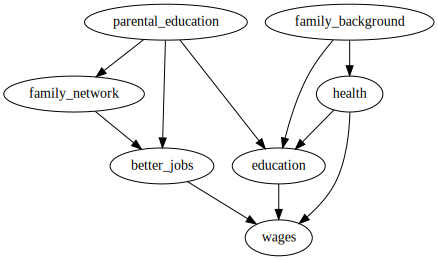

In [4]:
#This is the graph model I would like to generate data for.
c_graph = CausalGraphicalModel(
    nodes=["wages", "education", "family_background", "parental_education", "family_network", "better_jobs", "health"],
    edges=[
        ("education", "wages"), 
        ("education", "wages"), 
        ("family_background", "education"),
        ("parental_education", "education"), 
        ("better_jobs", "wages"),
        ("family_network", "better_jobs"), 
        ("health", "education"),
        #("education", "health"),
        ("health", "wages"),
        ("family_background", "health"),
        ("parental_education", "family_network"),
        ("parental_education", "better_jobs")
        
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
c_graph.draw()

# Relationship intuition derived from here: https://largescaleassessmentsineducation.springeropen.com/articles/10.1186/s40536-017-0045-7#Tab2

In [5]:
def datagenerate(n = 1000, seed = 0, alpha_w = 0.5, alpha_e = 0.7, beta_qe = 0.09):
  '''
      # e = education
      # w = wages
      # q = exogenoeous variation on education, for example public security of environment, condition of roads to school 
      # u = a measure of the individuals motivation to succeed in education and on the job
      # h = health
      # b = better_jobs
      # fn = family_network
      # fb = family_background
      # pe = parental_education
      # n = number of observations
      # alpha_w = 0.5 # a constant
      # alpha_ew = 0 #means education would not have any effect on the wage's rate. This will help us in testing if our extimation technique can recover this value of 0
      # alpha_e = 0.7 # constant
      # beta_qe = 0.09 # effect of the exogeneous variation

  '''

  
  q = tf.random.uniform([n]) # exogeneous variation which is uniform across all entries/observation in our data
  
  u = tf.random.normal([n]) # we assume our motivation variable takes a normal distribution

  #pe variable with respect to motivation/exogenous variable
  pe = alpha_w + u + tf.random.normal([n])

  #fb variable with respect to motivation/exogenous variable
  fb = alpha_e + u + tf.random.normal([n])

  #generate fn variable based on pe and motivation/exogenous variable
  fn = 0.33 * pe + u + tf.random.normal([n])

  #generate h variable based on fb and motivation/exogenous variable
  h = 0.5 * fb + u + tf.random.normal([n])

  #generate e variable based on fb, pe and motivation/exogenous variable
  e = 0.33 * pe + (0.5 * fb) + (0.5 * h) + u + tf.random.normal([n])

  #generate b variable based on pe and fn and motivation/exogenous variable
  b = 0.33 * pe + (0.5 * fn) + u + tf.random.normal([n])

  #generate w variable based on e, b, h and motivation/exogenous variable
  w = 0.5 * e + (alpha_w * b) + (0.5 * h) + u + tf.random.normal([n]) # Here we specify the wage


  df = pd.DataFrame({"parental_education":pe,"family_background":fb, "family_network":fn,"health":h,"education":e, "better_jobs":b, "wages":w}) # Here we read the data into a pandas dataframe

  return df

In [6]:
df = datagenerate(n = 2000, alpha_w = 0.5, alpha_e = 0.7, beta_qe = 0.09)
df.head()

parental_education  family_background  family_network    health  education  \
0            0.207671           1.847649       -0.083174  3.280942   4.285316   
1            3.380199           2.576559        2.633601  1.415008   3.435518   
2           -0.117880          -1.546500       -3.763627 -2.989789  -5.023353   
3           -1.485927          -2.263545       -1.589409 -1.525716  -2.765189   
4           -0.158690           0.599269        1.490949  0.517870   0.053094   

   better_jobs     wages  
0     0.408569  5.094026  
1     2.551922  3.042929  
2    -4.172112 -7.317294  
3    -3.944183 -3.624460  
4     1.798772  0.325846

In [7]:
#http://www.degeneratestate.org/posts/2018/Jul/10/causal-inference-with-python-part-2-causal-graphical-models/

In [8]:
#df.to_csv("/content/drive/MyDrive/Fall_2022/IS_800_Causality_New/Team_Project/syn_data.csv")

In [9]:
df = pd.read_csv("/content/drive/MyDrive/Fall_2022/IS_800_Causality_New/Team_Project/syn_data.csv")

In [10]:
model = smf.ols("education ~ wages", data = df) # Here we run our regression using stats.module

In [11]:
results = model.fit()

In [12]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              education   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                 1.296e+04
Date:                Thu, 08 Dec 2022   Prob (F-statistic):               0.00
Time:                        23:07:20   Log-Likelihood:                -2954.5
No. Observations:                2000   AIC:                             5913.
Df Residuals:                    1998   BIC:                             5924.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2900      0.024     12.131      0.0

#Constraint - Based Structure Learning

###PC Algorithm###

In [13]:
df1 = df.to_numpy()

  0%|          | 0/8 [00:00<?, ?it/s]

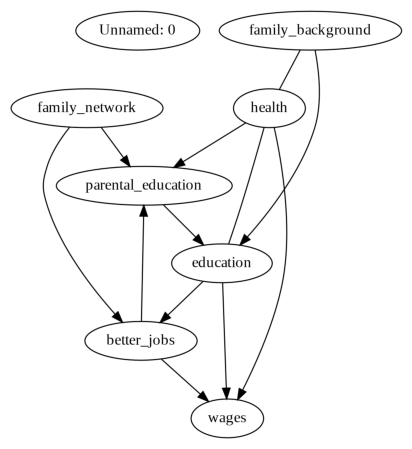

In [14]:
# significance level (alpha) at 0.05
# Here I used “fisherz”: Fisher’s Z conditional independence test because there are no missing values in the data, otherwise “mv_fisherz”
cg = pc(df1, 0.05, fisherz, True, 0, -1)

plt.figure(figsize=(12,8))

# visualization using pydot
cols = df.columns
cg.draw_pydot_graph(labels=cols)

###Fast Causal Inference - FCI Algorithm###

Starting Fast Adjacency Search.


  0%|          | 0/8 [00:00<?, ?it/s]

Finishing Fast Adjacency Search.
X2 --> X6
X6 --> X8


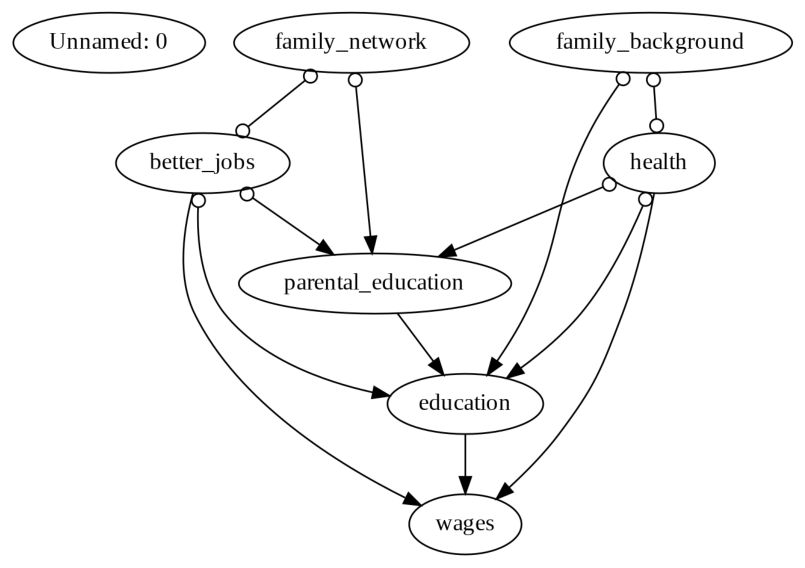

In [15]:
from causallearn.search.ConstraintBased.FCI import fci

G, edges = fci(df1, fisherz, 0.05, -1, -1, )

# visualization
from causallearn.utils.GraphUtils import GraphUtils
cols = df.columns
pdy = GraphUtils.to_pydot(G, labels=cols)
#pdy.write_png('simple_test.png')

plt.figure(figsize=(12,8))

# Visualization using pydot
#pyd = GraphUtils.to_pydot(Record['G'], labels=cols)
tmp_png = pdy.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

#Score-based Causal Discovery
###Greedy Equivalence Search (GES) Algorithm###

[[ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 -1]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0]]
[[ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 -1]
 [ 0  0  0  0  0  0  0 -1]
 [ 0  0  0  0  0 -1  1  0]]
[[ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 -1]
 [ 0  0  0  0  0  0  0 -1]
 [ 0  0  0  0  0  0  0 -1]
 [ 0  0  0  0  1 -1 -1  0]]
[[ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0 -1]
 [ 0  0  0  0  0  0  0 -1]
 [ 0  0  0 -1  0  0  0 -1]
 [ 0  0  0  0 -1 -1 -1  0]]
[[ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 -1  0  0]
 [ 0  0  0  0  0  0 -1  0]
 [ 0  0  0  0  0  0  0 -

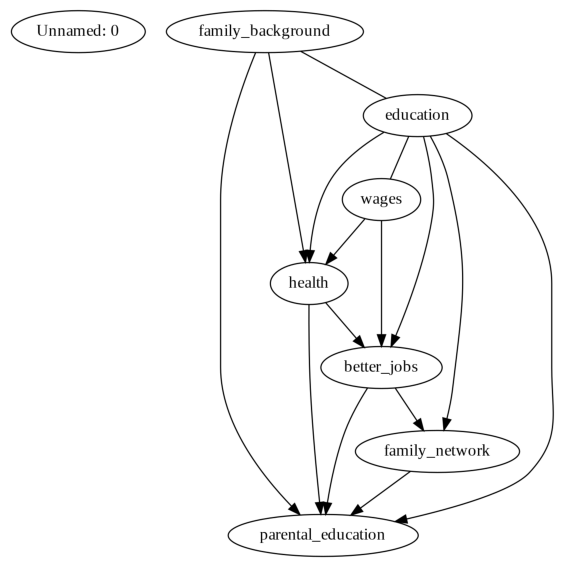

In [16]:
Record = ges(df1, score_func = "local_score_BIC", maxP = None, parameters = None)
cols = df.columns

plt.figure(figsize=(12,8))

# Visualization using pydot
pyd = GraphUtils.to_pydot(Record['G'], labels=cols)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

In [17]:
def func_1(A, B, r, beta):
    return A * (r - r * A - beta * B)

## CCM Algorithm

### Defining CCM Functions

In [18]:
# Computing "Causality" (Correlation between True and Predictions)
class ccm:
    def __init__(self, X, Y, tau=1, E=2, L=500):
        '''
        X: timeseries for variable X that could cause Y
        Y: timeseries for variable Y that could be caused by X
        tau: time lag
        E: shadow manifold embedding dimension
        L: time period/duration to consider (longer = more data)
        We're checking for X -> Y
        '''
        self.X = X
        self.Y = Y
        self.tau = tau
        self.E = E
        self.L = L        
        self.My = self.shadow_manifold(Y) # shadow manifold for Y (we want to know if info from X is in Y)
        self.t_steps, self.dists = self.get_distances(self.My) # for distances between points in manifold    

In [19]:
%%add_to ccm
def shadow_manifold(self, X):
    """
    Given
        X: some time series vector
        tau: lag step
        E: shadow manifold embedding dimension
        L: max time step to consider - 1 (starts from 0)
    Returns
        {t:[t, t-tau, t-2*tau ... t-(E-1)*tau]} = Shadow attractor manifold, dictionary of vectors
    """
    X = X[:L] # make sure we cut at L
    M = {t:[] for t in range((self.E-1) * self.tau, self.L)} # shadow manifold
    for t in range((self.E-1) * self.tau, self.L):
        x_lag = [] # lagged values
        for t2 in range(0, self.E-1 + 1): # get lags, we add 1 to E-1 because we want to include E
            x_lag.append(X[t-t2*self.tau])            
        M[t] = x_lag
    return M

In [20]:
%%add_to ccm

# get pairwise distances between vectors in X
def get_distances(self, Mx):
    """
    Args
        Mx: The shadow manifold from X
    Returns
        t_steps: timesteps
        dists: n x n matrix showing distances of each vector at t_step (rows) from other vectors (columns)
    """

    # we extract the time indices and vectors from the manifold Mx
    # we just want to be safe and convert the dictionary to a tuple (time, vector)
    # to preserve the time inds when we separate them
    t_vec = [(k, v) for k,v in Mx.items()]
    t_steps = np.array([i[0] for i in t_vec])
    vecs = np.array([i[1] for i in t_vec])
    dists = distance.cdist(vecs, vecs)    
    return t_steps, dists

In [21]:
%%add_to ccm

def get_nearest_distances(self, t, t_steps, dists):
    """
    Args:
        t: timestep of vector whose nearest neighbors we want to compute
        t_teps: time steps of all vectors in Mx, output of get_distances()
        dists: distance matrix showing distance of each vector (row) from other vectors (columns). output of get_distances()
        E: embedding dimension of shadow manifold Mx 
    Returns:
        nearest_timesteps: array of timesteps of E+1 vectors that are nearest to vector at time t
        nearest_distances: array of distances corresponding to vectors closest to vector at time t
    """
    t_ind = np.where(t_steps == t) # get the index of time t
    dist_t = dists[t_ind].squeeze() # distances from vector at time t (this is one row)
    
    # get top closest vectors
    nearest_inds = np.argsort(dist_t)[1:self.E+1 + 1] # get indices sorted, we exclude 0 which is distance from itself
    nearest_timesteps = t_steps[nearest_inds] # index column-wise, t_steps are same column and row-wise 
    nearest_distances = dist_t[nearest_inds]  
    
    return nearest_timesteps, nearest_distances


In [22]:
%%add_to ccm
def predict(self, t):
    """
    Args
        t: timestep at Mx to predict Y at same time step
    Returns
        Y_true: the true value of Y at time t
        Y_hat: the predicted value of Y at time t using Mx
    """
    eps = 0.000001 # epsilon minimum distance possible
    t_ind = np.where(self.t_steps == t) # get the index of time t
    dist_t = self.dists[t_ind].squeeze() # distances from vector at time t (this is one row)    
    nearest_timesteps, nearest_distances = self.get_nearest_distances(t, self.t_steps, self.dists)    
    
    # get weights
    u = np.exp(-nearest_distances/np.max([eps, nearest_distances[0]])) # we divide by the closest distance to scale
    w = u / np.sum(u)
    
    # get prediction of X
    X_true = self.X[t] # get corresponding true X
    X_cor = np.array(self.X)[nearest_timesteps] # get corresponding Y to cluster in Mx
    X_hat = (w * X_cor).sum() # get X_hat
    
    return X_true, X_hat
    
    

In [23]:
%%add_to ccm
def causality(self):
    '''
    Args:
        None
    Returns:
        correl: how much self.X causes self.Y. correlation between predicted Y and true Y
    '''

    # run over all timesteps in M
    # X causes Y, we can predict X using My
    # X puts some info into Y that we can use to reverse engineer X from Y        
    X_true_list = []
    X_hat_list = []

    for t in list(self.My.keys()): # for each time step in My
        X_true, X_hat = self.predict(t) # predict X from My
        X_true_list.append(X_true)
        X_hat_list.append(X_hat) 

    x, y = X_true_list, X_hat_list
    r, p = pearsonr(x, y)        

    return r, p


### Functions for Visualizing

In [24]:
%%add_to ccm

def visualize_cross_mapping(self):
    """
    Visualize the shadow manifolds and some cross mappings
    """
    # we want to check cross mapping from Mx to My and My to Mx

    f, axs = plt.subplots(1, 2, figsize=(12, 6))        
    
    for i, ax in zip((0, 1), axs): # i will be used in switching Mx and My in Cross Mapping visualization
        #===============================================
        # Shadow Manifolds Visualization

        X_lag, Y_lag = [], []
        for t in range(1, len(self.X)):
            X_lag.append(X[t-tau])
            Y_lag.append(Y[t-tau])    
        X_t, Y_t = self.X[1:], self.Y[1:] # remove first value

        ax.scatter(X_t, X_lag, s=5, label='$M_x$')
        ax.scatter(Y_t, Y_lag, s=5, label='$M_y$', c='y')

        #===============================================
        # Cross Mapping Visualization

        A, B = [(self.Y, self.X), (self.X, self.Y)][i]
        cm_direction = ['Mx to My', 'My to Mx'][i]

        Ma = self.shadow_manifold(A)
        Mb = self.shadow_manifold(B)

        t_steps_A, dists_A = self.get_distances(Ma) # for distances between points in manifold
        t_steps_B, dists_B = self.get_distances(Mb) # for distances between points in manifold

        # Plot cross mapping for different time steps
        timesteps = list(Ma.keys())
        for t in np.random.choice(timesteps, size=3, replace=False):
            Ma_t = Ma[t]
            near_t_A, near_d_A = self.get_nearest_distances(t, t_steps_A, dists_A)

            for i in range(E+1):
                # points on Ma
                A_t = Ma[near_t_A[i]][0]
                A_lag = Ma[near_t_A[i]][1]
                ax.scatter(A_t, A_lag, c='b', marker='s')

                # corresponding points on Mb
                B_t = Mb[near_t_A[i]][0]
                B_lag = Mb[near_t_A[i]][1]
                ax.scatter(B_t, B_lag, c='r', marker='*', s=50)  

                # connections
                ax.plot([A_t, B_t], [A_lag, B_lag], c='r', linestyle=':') 

        ax.set_title(f'{cm_direction} cross mapping. time lag, tau = {tau}, E = 2')
        ax.legend(prop={'size': 14})

        ax.set_xlabel('$X_t$, $Y_t$', size=15)
        ax.set_ylabel('$X_{t-1}$, $Y_{t-1}$', size=15)               
    plt.show()       

In [25]:
%%add_to ccm
def plot_ccm_correls(self):
    """
    Args
        X: X time series
        Y: Y time series
        tau: time lag
        E: shadow manifold embedding dimension
        L: time duration
    Returns
        None. Just correlation plots
    """
    M = self.shadow_manifold(self.Y) # shadow manifold
    t_steps, dists = self.get_distances(M) # for distances

    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X

    X_My_true, X_My_pred = [], [] # note pred X | My is equivalent to figuring out if X -> Y
    Y_Mx_true, Y_Mx_pred = [], [] # note pred Y | Mx is equivalent to figuring out if Y -> X

    for t in range(tau, L):
        true, pred = ccm_XY.predict(t)
        X_My_true.append(true)
        X_My_pred.append(pred)    

        true, pred = ccm_YX.predict(t)
        Y_Mx_true.append(true)
        Y_Mx_pred.append(pred)        

    # # plot
    figs, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    # predicting X from My
    r, p = np.round(pearsonr(X_My_true, X_My_pred), 4)
    
    axs[0].scatter(X_My_true, X_My_pred, s=10)
    axs[0].set_xlabel('$X(t)$ (observed)', size=12)
    axs[0].set_ylabel('$\hat{X}(t)|M_y$ (estimated)', size=12)
    axs[0].set_title(f'tau={tau}, E={E}, L={L}, Correlation coeff = {r}')

    # predicting Y from Mx
    r, p = np.round(pearsonr(Y_Mx_true, Y_Mx_pred), 4)
    
    axs[1].scatter(Y_Mx_true, Y_Mx_pred, s=10)
    axs[1].set_xlabel('$Y(t)$ (observed)', size=12)
    axs[1].set_ylabel('$\hat{Y}(t)|M_x$ (estimated)', size=12)
    axs[1].set_title(f'tau={tau}, E={E}, L={L}, Correlation coeff = {r}')
    plt.show()


#Discovery Evaluation Metrics

We evaluate all the algorithms implemented on our sythethic data

#Implementation on Real World Dataset

In [26]:
df1 = pd.read_csv("/content/drive/MyDrive/Fall_2022/IS_800_Causality_New/Team_Project/sea_ice1.csv", index_col='Date', parse_dates=True)
df1

wind_10m  specific_humidity     LW_down     SW_down  rainfall  \
Date                                                                        
1979-01-01  5.872050           0.786595  184.999071    1.417925  1.089897   
1979-01-02  6.155597           0.756973  182.686318    1.368594  0.923499   
1979-01-03  5.691054           0.777598  186.387764    1.197913  1.218984   
1979-01-04  5.628824           0.819629  191.888081    1.405106  1.783778   
1979-01-05  6.255928           0.869896  190.541890    1.305893  0.995828   
...              ...                ...         ...         ...       ...   
2021-08-27  5.386638           4.563584  305.197693  102.101318  2.559692   
2021-08-28  5.234190           4.366545  302.980530  102.355118  1.951954   
2021-08-29  4.675841           4.300599  302.045685   98.769402  1.618767   
2021-08-30  4.396615           4.272134  300.618896   99.093216  1.643894   
2021-08-31  4.430712           4.206679  298.726013   94.778908  1.605882   

            snowfall         sst         t2m  surface_pressure  sea_ice_extent  
Date                                                                            
1979-01-01  1.031549  273.379711  250.401819        979.401142      14997215.0  
1979-01-02  0.837877  273.376830  250.364683        979.340886      14997215.0  
1979-01-03  1.066028  273.385489  250.452749        983.409060      14997215.0  
1979-01-04  1.448627  273.396461  250.290579        983.557055      14922219.0  
1979-01-05  0.776768  273.404602  250.895886        978.020927      14922219.0  
...              ...         ...         ...               ...             ...  
2021-08-27  0.388835  278.514526  278.483246        980.477173       5279000.0  
2021-08-28  0.489219  278.515076  277.969543        981.036499       5268000.0  
2021-08-29  0.333258  278.482941  277.669586        981.798767       5189000.0  
2021-08-30  0.335707  278.492828  277.581635        983.147156       5157000.0  
2021-08-31  0.265257  278.460632  277.484070        984.148193       5199000.0  

[15584 rows x 10 columns]

In [27]:
df1.describe()

wind_10m  specific_humidity       LW_down       SW_down  \
count  15584.000000       15584.000000  15584.000000  15584.000000   
mean       5.159636           2.356239    242.917655     96.988448   
std        0.594864           1.507268     44.847910     89.846181   
min        3.563044           0.514766    161.390858      0.699326   
25%        4.704933           1.054696    200.067186      8.881082   
50%        5.136824           1.733097    236.759579     70.114694   
75%        5.576375           3.669206    286.968939    183.203147   
max        8.025901           5.838770    321.611237    271.515120   

           rainfall      snowfall           sst           t2m  \
count  15584.000000  15584.000000  15584.000000  15584.000000   
mean       1.388352      0.715891    274.783903    265.004380   
std        0.409100      0.333644      1.653564     10.789043   
min        0.422104      0.021246    272.968951    243.275692   
25%        1.067119      0.459149    273.435405    254.476638   
50%        1.342988      0.747681    274.067672    264.472376   
75%        1.678361      0.949787    276.046552    276.067807   
max        3.263371      1.974792    279.302979    281.875844   

       surface_pressure  sea_ice_extent  
count      15584.000000    1.558400e+04  
mean         981.164635    1.138315e+07  
std            4.550959    3.285968e+06  
min          962.788416    3.339905e+06  
25%          978.312383    8.666014e+06  
50%          981.112151    1.210357e+07  
75%          984.007839    1.426088e+07  
max          999.949341    1.663481e+07

In [28]:
df1.dtypes

wind_10m             float64
specific_humidity    float64
LW_down              float64
SW_down              float64
rainfall             float64
snowfall             float64
sst                  float64
t2m                  float64
surface_pressure     float64
sea_ice_extent       float64
dtype: object

In [29]:
df2 = df1.values

In [30]:
# def mean(x): # np.mean(X, axis = 0)  
#     return sum(x)/len(x)  

# def std(x): # np.std(X, axis = 0)
#     return (sum((i - mean(x))**2 for i in x)/len(x))**0.5

# def Standardize_data(X):
#     return (X - mean(X))/std(X)


##Data Normalization - min-max feature scaling##

In [31]:
# copy the data
df1_norm = df1.copy()
  
# apply normalization techniques
for column in df1_norm.columns:
    df1_norm[column] = (df1_norm[column] - df1_norm[column].min()) / (df1_norm[column].max() - df1_norm[column].min())    
  
# view normalized data
print(df1_norm)

            wind_10m  specific_humidity   LW_down   SW_down  rainfall  \
Date                                                                    
1979-01-01  0.517383           0.051057  0.147348  0.002653  0.235034   
1979-01-02  0.580918           0.045493  0.132914  0.002471  0.176469   
1979-01-03  0.476827           0.049367  0.156016  0.001841  0.280466   
1979-01-04  0.462883           0.057262  0.190345  0.002606  0.479249   
1979-01-05  0.603399           0.066704  0.181943  0.002240  0.201925   
...              ...                ...       ...       ...       ...   
2021-08-27  0.408616           0.760484  0.897556  0.374432  0.752336   
2021-08-28  0.374456           0.723474  0.883718  0.375369  0.538440   
2021-08-29  0.249346           0.711088  0.877884  0.362128  0.421172   
2021-08-30  0.186779           0.705741  0.868978  0.363324  0.430016   
2021-08-31  0.194420           0.693447  0.857164  0.347393  0.416637   

            snowfall       sst       t2m  surface_

##Let's compute correlations between variables in our time series##
The correlation coefficient can be used to determine how multiple variables are associated with one another. The result is a correlation matrix that describes the correlation between time series variables. Note that the diagonal values in a correlation matrix will always be 1, since a time series will always be perfectly correlated with itself.

Correlation coefficients can be computed with the pearson, kendall and spearman methods. We use the pearson method because we assume that relationships between our variables are thought to be linear.

In [32]:
df1_norm[['sea_ice_extent', 'wind_10m', "specific_humidity",	"LW_down",	"SW_down",	"rainfall",	"snowfall",	"sst",	"t2m",	"surface_pressure"]].corr(method='pearson')

sea_ice_extent  wind_10m  specific_humidity   LW_down  \
sea_ice_extent           1.000000  0.262960          -0.693728 -0.729400   
wind_10m                 0.262960  1.000000          -0.629033 -0.620325   
specific_humidity       -0.693728 -0.629033           1.000000  0.972862   
LW_down                 -0.729400 -0.620325           0.972862  1.000000   
SW_down                 -0.071552 -0.641237           0.655827  0.695082   
rainfall                -0.744676 -0.125110           0.662675  0.659789   
snowfall                 0.335932  0.726687          -0.789488 -0.724907   
sst                     -0.925236 -0.405191           0.849068  0.827543   
t2m                     -0.695374 -0.628045           0.953693  0.993157   
surface_pressure         0.159860 -0.227228          -0.049247 -0.012074   

                    SW_down  rainfall  snowfall       sst       t2m  \
sea_ice_extent    -0.071552 -0.744676  0.335932 -0.925236 -0.695374   
wind_10m          -0.641237 -0.125110  0.726687 -0.405191 -0.628045   
specific_humidity  0.655827  0.662675 -0.789488  0.849068  0.953693   
LW_down            0.695082  0.659789 -0.724907  0.827543  0.993157   
SW_down            1.000000  0.135979 -0.676368  0.237112  0.744271   
rainfall           0.135979  1.000000 -0.167810  0.753770  0.616329   
snowfall          -0.676368 -0.167810  1.000000 -0.562797 -0.721770   
sst                0.237112  0.753770 -0.562797  1.000000  0.788353   
t2m                0.744271  0.616329 -0.721770  0.788353  1.000000   
surface_pressure   0.210712 -0.322692 -0.167637 -0.127715  0.010080   

                   surface_pressure  
sea_ice_extent             0.159860  
wind_10m                  -0.227228  
specific_humidity         -0.049247  
LW_down                   -0.012074  
SW_down                    0.210712  
rainfall                  -0.322692  
snowfall                  -0.167637  
sst                       -0.127715  
t2m                        0.010080  
surface_pressure           1.000000

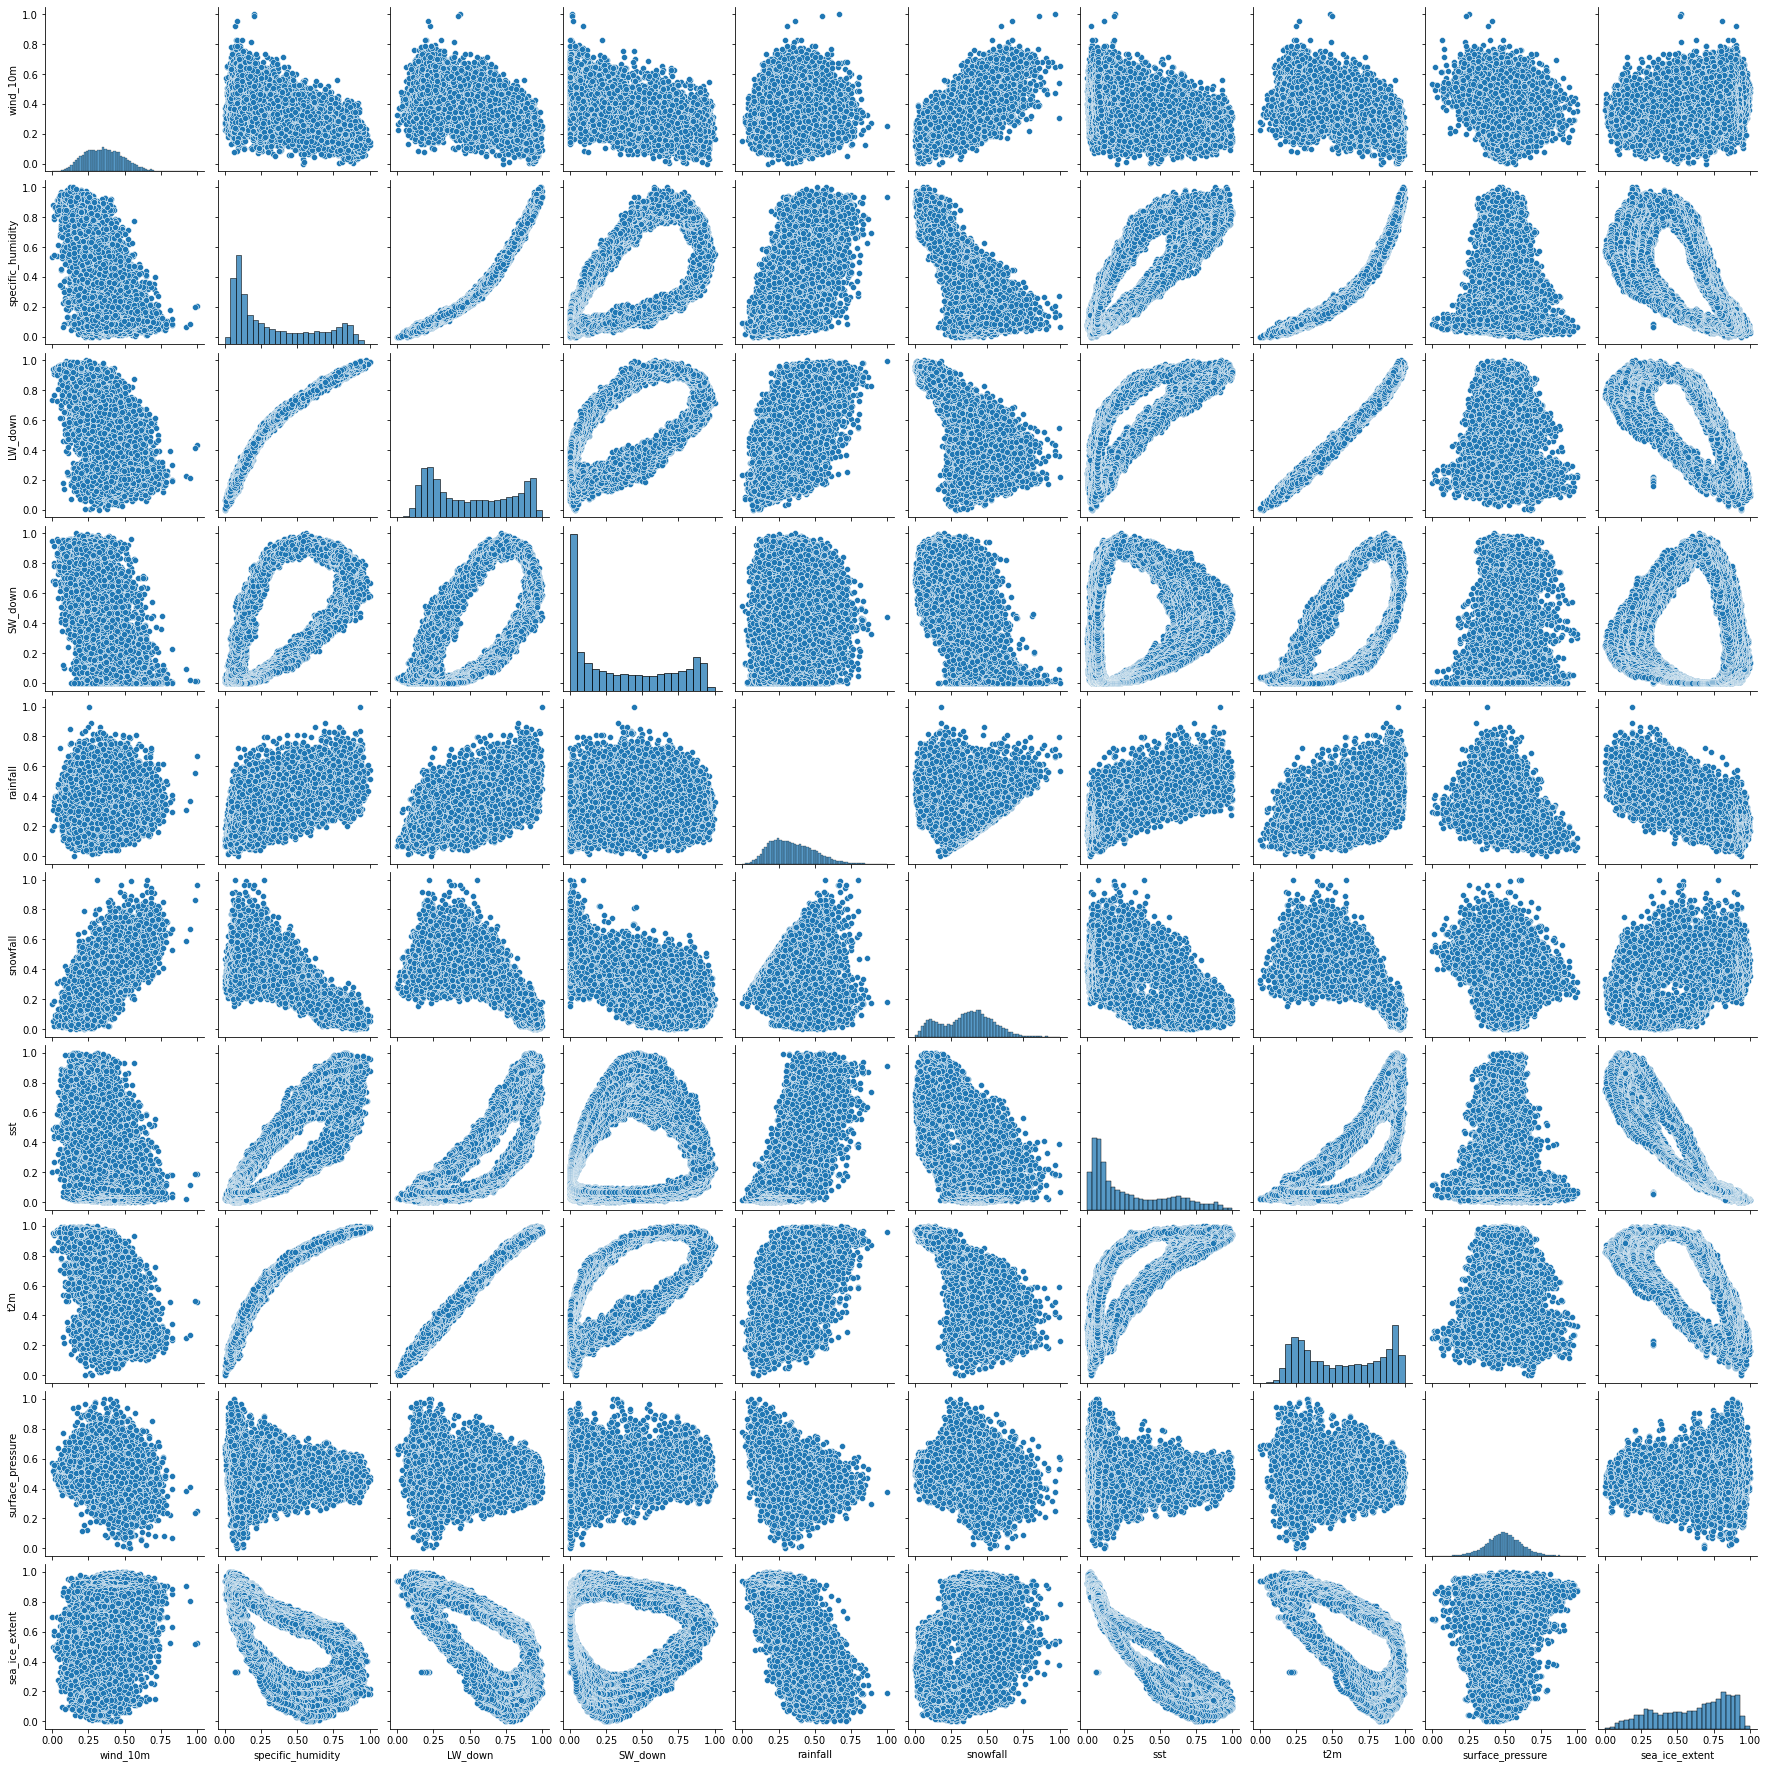

In [33]:
sns.pairplot(df1_norm)

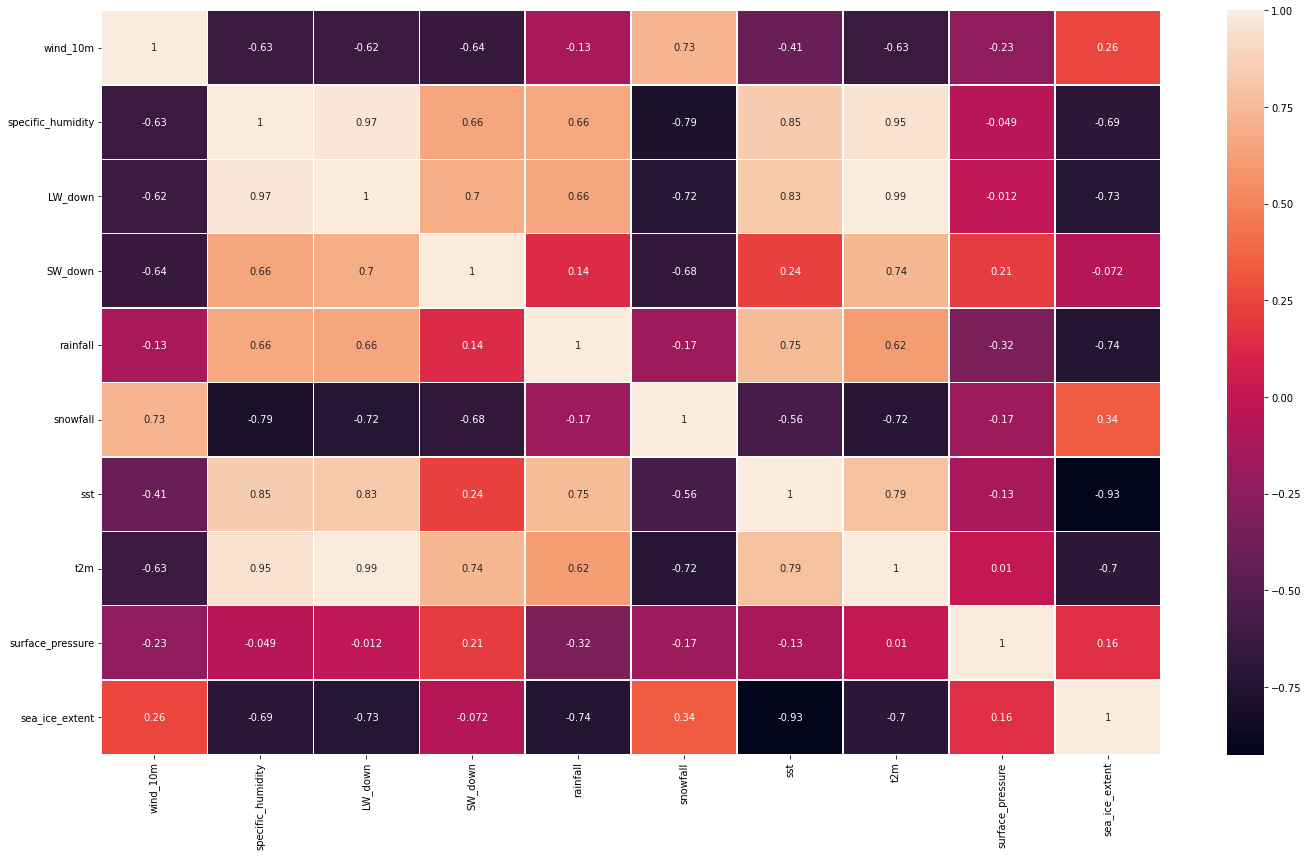

In [34]:
corr_df1_norm = df1_norm.corr(method='pearson')

# Customize the heatmap of the corr_meat correlation matrix
sns.heatmap(corr_df1_norm,
           annot=True,
           linewidths=0.4,
           annot_kws={'size': 10});

plt.xticks(rotation=90);
plt.yticks(rotation=0);
plt.savefig('/content/drive/MyDrive/Fall_2022/IS_800_Causality_New/Team_Project/Images/heatmap_all.png')

##Clustered heatmaps##
Heatmaps are extremely useful to visualize a correlation matrix, but clustermaps are better. A Clustermap allows to uncover structure in a correlation matrix by producing a hierarchically-clustered heatmap:

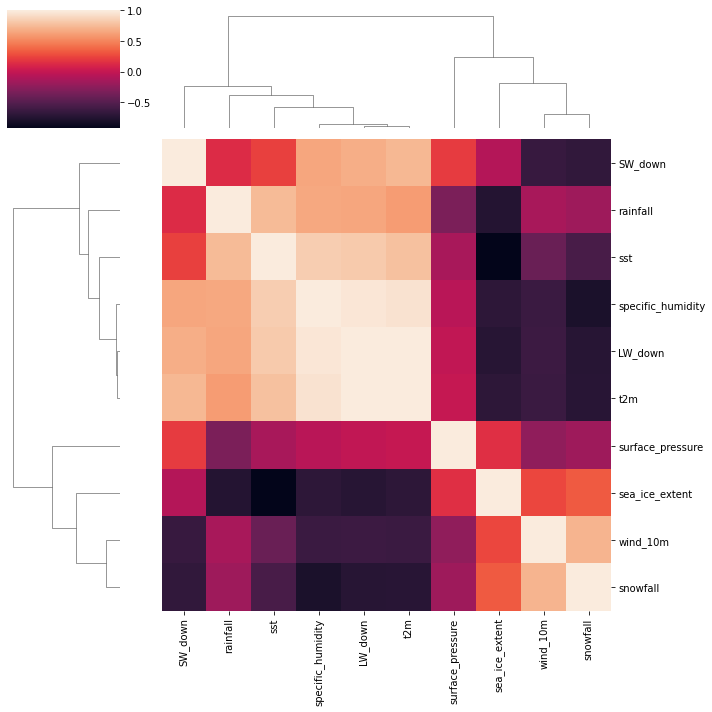

In [35]:
corr_df1 = df1_norm.corr(method='pearson')

# Customize the heatmap of the corr_meat correlation matrix
fig = sns.clustermap(corr_df1,
               row_cluster=True,
               col_cluster=True,
               figsize=(10, 10));

plt.setp(fig.ax_heatmap.xaxis.get_majorticklabels(), rotation=90);
plt.setp(fig.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
plt.savefig('/content/drive/MyDrive/Fall_2022/IS_800_Causality_New/Team_Project/Images/clustermap.png')

#Data Preprocessing
###Handling of missing values

In [36]:
#https://towardsdatascience.com/transformer-unleashed-deep-forecasting-of-multivariate-time-series-in-python-9ca729dac019
def missing(X):
  '''
  Input: X : The dataframe
  Output : When no missing values, it prints: no missing values
          When missing values are present, it prints them, and replaces them with neighbors
  '''
  if df.isnull().values.any():
      print("MISSING values:\n")
      mno.matrix(X)
      X = X.interpolate(method ="bfill")
      print(X)
  else:
      print("no missing values\n")
missing(df1_norm)  

no missing values



In [37]:
# # drop the NaN and zero columns, and also the 'forecast' columns
# df1 = df1.drop(df1.filter(regex="forecast").columns, axis=1, errors="ignore")
# df1.dropna(axis=1, how="all", inplace=True)
# df1 = df1.loc[:, (df1!=0).any(axis=0)]


# #handle missing values in rows of remaining columns
# df1 = df1.interpolate(method ="bfill")
# #any missing values left?
# gaps(df1)

# df1 = df1.loc[:, (df1!=0).any(axis=0)]

Outliers Detection 

In [38]:
# #https://towardsdatascience.com/transformer-unleashed-deep-forecasting-of-multivariate-time-series-in-python-9ca729dac019
# #boxplots
# for i, c in enumerate(df1_norm.columns):
#     sns.boxplot(x=df1_norm[c], palette="coolwarm")
#     plt.show();
    

###Should we drop outliars or replace them with interpolated values???

Approach 1. Quantile based flooring and capping

In this technique, the outlier is capped at a certain value above the 90th percentile value or floored at a factor below the 10th percentile value.

In [39]:
#https://www.analyticsvidhya.com/blog/2021/05/detecting-and-treating-outliers-treating-the-odd-one-out/

# for i in df1_norm.columns:

#   # Computing 10th, 90th percentiles and replacing the outliers
#   tenth_percentile = np.percentile(i, 10)
#   ninetieth_percentile = np.percentile(i, 90)
#   # print(tenth_percentile, ninetieth_percentile)
#   b = np.where(i<tenth_percentile, tenth_percentile, i)
#   b_i = np.where(b>ninetieth_percentile, ninetieth_percentile, b)
#   # print("Sample:", sample)
#   print("New array:",b_i)

In [40]:
#plt.plot(df1_norm.index, df1_norm[['sea_ice_extent']])

Approach 2. Mean/Median imputation

As the mean value is highly influenced by the outliers, it is advised to replace the outliers with the median value.

In [41]:
# median = np.median(sample)# Replace with median
# for i in sample_outliers:
#     c = np.where(sample==i, 14, sample)
# print("Sample: ", sample)
# print("New array: ",c)
# # print(x.dtype)

#Time series Pre-processing

###Stationarity Check

A stationarity time series is a series whose statistical properties, such as mean, variance, etc., remain constant over time. In other words, its statistical properties are independent of the point in time at which they are observed.
On the other hand, a time series whose statistical properties change over time is called a non-stationary time series. Thus a time series with a trend or seasonality is non-stationary in nature. This is because the presence of trend or seasonality will affect the mean, variance and other properties at any given point in time.

It is important to stationarize our data so that the inferences drawn will be reliable because of a constant mean and variance. Analysis analysis or forecasts made using a non-stationary data are often erroneous and misleading.


##We use Statistical Tests (ADF) and Summary Statistics approaches


###Augmented Dickey-Fuller Test - This test relies on the following:
 
*   Null Hypothesis, H0: The time series is not stationary.
*   Alternative Hypothesis, H1: The time series is stationary.


*   If the p-value is less than or equal to 0.05 or the absolute value of the test statistics is greater than the critical value, you reject H0 and conclude that the time series is stationary.

*   If the p-value is greater than 0.05 or the absolute value of the test statistics is less than the critical value, you fail to reject H0 and conclude that the time series is not stationary.



*   From the results, the p-value is less than 0.05. So we reject the null hypothesis and conclude that the time series is stationary.






In [42]:
#https://otexts.com/fpp2/stationarity.html

In [43]:
#https://blog.quantinsti.com/stationarity/
# Import adfuller
from statsmodels.tsa.stattools import adfuller

for i in df1_norm.columns:
  result = adfuller(df1_norm[[i]])
  print('')
  print('For variable: ', i)
  print('ADF Test Statistic: %.2f' % result[0])
  print('5%% Critical Value: %.2f' % result[4]['5%'])
  print('p-value: %.2f'  % result[1])


For variable:  wind_10m
ADF Test Statistic: -9.12
5% Critical Value: -2.86
p-value: 0.00

For variable:  specific_humidity
ADF Test Statistic: -20.05
5% Critical Value: -2.86
p-value: 0.00

For variable:  LW_down
ADF Test Statistic: -19.93
5% Critical Value: -2.86
p-value: 0.00

For variable:  SW_down
ADF Test Statistic: -25.00
5% Critical Value: -2.86
p-value: 0.00

For variable:  rainfall
ADF Test Statistic: -8.48
5% Critical Value: -2.86
p-value: 0.00

For variable:  snowfall
ADF Test Statistic: -11.74
5% Critical Value: -2.86
p-value: 0.00

For variable:  sst
ADF Test Statistic: -14.53
5% Critical Value: -2.86
p-value: 0.00

For variable:  t2m
ADF Test Statistic: -20.49
5% Critical Value: -2.86
p-value: 0.00

For variable:  surface_pressure
ADF Test Statistic: -17.72
5% Critical Value: -2.86
p-value: 0.00

For variable:  sea_ice_extent
ADF Test Statistic: -18.95
5% Critical Value: -2.86
p-value: 0.00


##Summary Statistics



*   Stationary time series has a constant mean, variance over time. Summary statistics like mean and variance are helpful in estimating whether a time series is stationary or not.
*   We partition the data into random periods and analyse the summary statistics for different periods. If the mean and variance of different partitions are very close to each other, the series is stationary.

*   If there is a significant difference between the mean and variance of the different partitions, then the series is not stationary.









In [44]:
for i in df1_norm.columns:
  X = df1_norm[[i]]
  split = round(len(X) / 2)
  X1, X2 = X[0:split], X[split:]
  mean1, mean2 = X1.mean(), X2.mean()
  var1, var2 = X1.var(), X2.var()
  print('')
  print('For variable: ', i)
  print('mean1=%f, mean2=%f' % (mean1, mean2))
  print('variance1=%f, variance2=%f' % (var1, var2))


For variable:  wind_10m
mean1=0.357196, mean2=0.358305
variance1=0.017862, variance2=0.017674

For variable:  specific_humidity
mean1=0.326994, mean2=0.364769
variance1=0.077326, variance2=0.082271

For variable:  LW_down
mean1=0.487132, mean2=0.530551
variance1=0.079715, variance2=0.076056

For variable:  SW_down
mean1=0.352307, mean2=0.358797
variance1=0.109424, variance2=0.110700

For variable:  rainfall
mean1=0.330295, mean2=0.349858
variance1=0.020255, variance2=0.021019

For variable:  snowfall
mean1=0.363113, mean2=0.348051
variance1=0.027594, variance2=0.030634

For variable:  sst
mean1=0.235641, mean2=0.337439
variance1=0.050736, variance2=0.080396

For variable:  t2m
mean1=0.540298, mean2=0.585536
variance1=0.080068, variance2=0.075167

For variable:  surface_pressure
mean1=0.492273, mean2=0.496735
variance1=0.015545, variance2=0.014443

For variable:  sea_ice_extent
mean1=0.653447, mean2=0.556526
variance1=0.052011, variance2=0.065476


##Here we visualize individual variables to observe stationarity



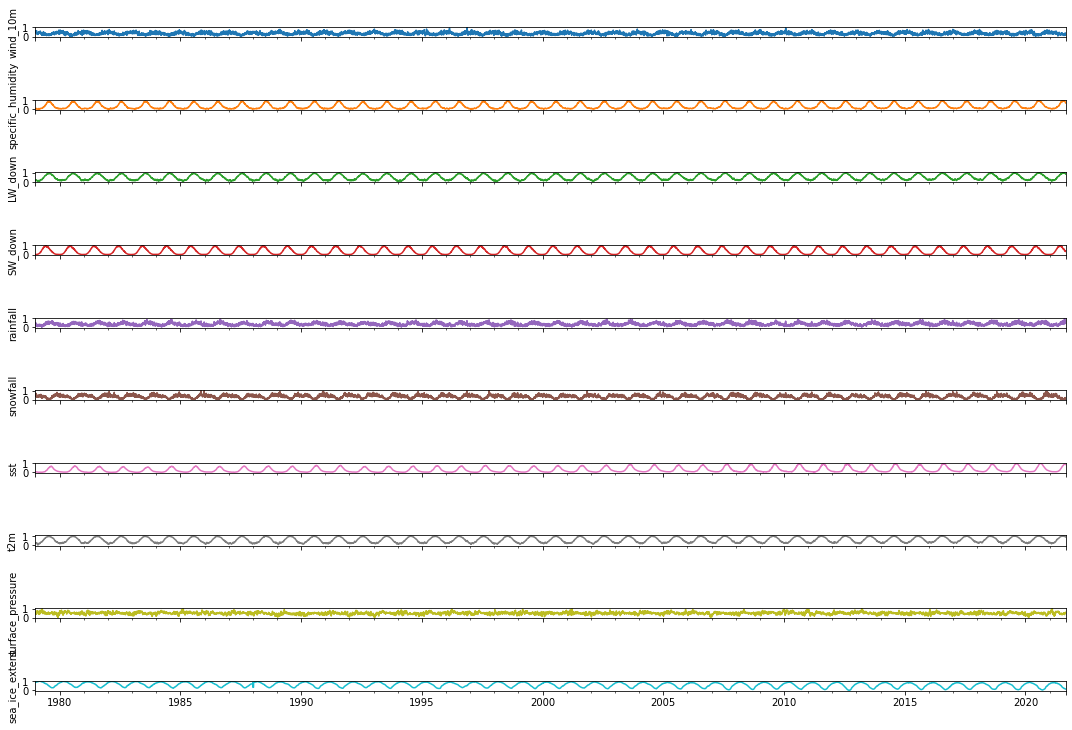

In [45]:
fig,ax = plt.subplots(10, figsize=(15,10), sharex=True)
plot_cols = ['wind_10m',	'specific_humidity',	'LW_down',	'SW_down',	'rainfall',	'snowfall',	'sst',	't2m',	'surface_pressure',	'sea_ice_extent']
#plot_cols = ['wind_10m',	'SW_down',	'rainfall',	'snowfall',	'sst',	'sea_ice_extent']
df1_norm[plot_cols].plot(subplots=True, legend=False, ax=ax)
for a in range(len(ax)): 
    ax[a].set_ylabel(plot_cols[a])
ax[-1].set_xlabel('')
plt.tight_layout()
plt.show()



Out dataset looks like its stationary since we can observe a constant variance. Also data points seem to always return towards the long-run mean. But just looking with the bear eye can't reveal some hidden aspects. Let's consider statistical testing with a parametric approach to detect stationarity: 

Here we randomly pick a varible to examine all its time series components and observe the following:


*   It contains no seasonal or cyclical trend
*   It contains zero residuals


<Figure size 864x360 with 0 Axes>

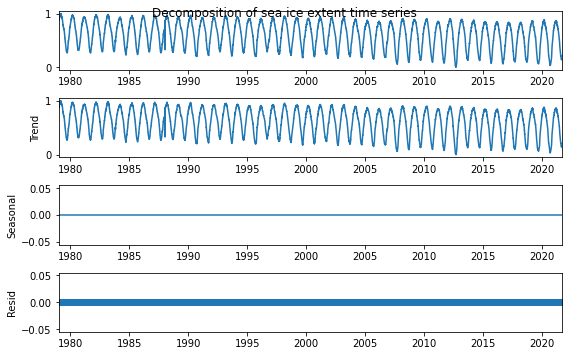

In [46]:
plt.figure(figsize=(12,5))
#series = [i+randrange(10) for i in range(1,100)]
df2 = df1_norm[['sea_ice_extent']]
result = seasonal_decompose(df2, model='additive', period=1)

trend = result.trend
seasonal = result.seasonal
residual = result.resid

fig = result.plot()
fig.set_figwidth(8)
fig.set_figheight(5)
fig.suptitle('Decomposition of sea ice extent time series')
plt.show()

#pyplot.show()

In [47]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range=(0,1))
# array = scaler.fit_transform(np.array(df).reshape(-1,1))

###Important Links###


*   https://www.kaggle.com/code/abhishekmamidi/time-series-preprocessing-to-modelling/notebook

*   https://towardsdatascience.com/fun-with-arma-var-and-granger-causality-6fdd29d8391c



*   https://phdinds-aim.github.io/time_series_handbook/06_ConvergentCrossMappingandSugiharaCausality/ccm_sugihara.html#






Feature Engineering

So our algorithms can run smoothly, we select variables which are highly correlated with our response or outcome variable.

In [48]:
df1_norm

wind_10m  specific_humidity   LW_down   SW_down  rainfall  \
Date                                                                    
1979-01-01  0.517383           0.051057  0.147348  0.002653  0.235034   
1979-01-02  0.580918           0.045493  0.132914  0.002471  0.176469   
1979-01-03  0.476827           0.049367  0.156016  0.001841  0.280466   
1979-01-04  0.462883           0.057262  0.190345  0.002606  0.479249   
1979-01-05  0.603399           0.066704  0.181943  0.002240  0.201925   
...              ...                ...       ...       ...       ...   
2021-08-27  0.408616           0.760484  0.897556  0.374432  0.752336   
2021-08-28  0.374456           0.723474  0.883718  0.375369  0.538440   
2021-08-29  0.249346           0.711088  0.877884  0.362128  0.421172   
2021-08-30  0.186779           0.705741  0.868978  0.363324  0.430016   
2021-08-31  0.194420           0.693447  0.857164  0.347393  0.416637   

            snowfall       sst       t2m  surface_pressure  sea_ice_extent  
Date                                                                        
1979-01-01  0.517164  0.064850  0.184614          0.447048        0.876826  
1979-01-02  0.418025  0.064395  0.183652          0.445427        0.876826  
1979-01-03  0.534813  0.065762  0.185933          0.554901        0.876826  
1979-01-04  0.730662  0.067494  0.181732          0.558884        0.871185  
1979-01-05  0.386744  0.068779  0.197414          0.409907        0.871185  
...              ...       ...       ...               ...             ...  
2021-08-27  0.188165  0.875521  0.912109          0.476004        0.145853  
2021-08-28  0.239551  0.875608  0.898801          0.491056        0.145025  
2021-08-29  0.159716  0.870535  0.891030          0.511568        0.139083  
2021-08-30  0.160970  0.872096  0.888751          0.547853        0.136676  
2021-08-31  0.124907  0.867013  0.886224          0.574791        0.139835  

[15584 rows x 10 columns]

In [49]:
# df1_norms = df1_norm.index.rename('date', inplace=True)
# df1_norms

In [50]:
#Here we consider only attributes with corr greater than 0.6
idxs = []

for i, corr in enumerate(corr_df1_norm['sea_ice_extent']):
    if corr > 0.1 and pd.notna(corr):
        idxs.append(i)
    else:
      corr < -0.71 and pd.notna(corr)
      idxs.append(i)


idxs = idxs[1:]
sel_feat = corr_df1_norm['sea_ice_extent'][idxs]
sel_feat

specific_humidity   -0.693728
LW_down             -0.729400
SW_down             -0.071552
rainfall            -0.744676
snowfall             0.335932
sst                 -0.925236
t2m                 -0.695374
surface_pressure     0.159860
sea_ice_extent       1.000000
Name: sea_ice_extent, dtype: float64

In [51]:
df3 = df1_norm.loc['2015-01-01':'2021-08-31']

In [52]:
# fig,ax = plt.subplots(6, figsize=(15,8), sharex=True)
# #plot_cols = ['wind_10m',	'specific_humidity',	'LW_down',	'SW_down',	'rainfall',	'snowfall',	'sst',	't2m',	'surface_pressure',	'sea_ice_extent']
# plot_cols = ['wind_10m',	'SW_down',	'rainfall',	'snowfall',	'sst',	'sea_ice_extent']
# df3[plot_cols].plot(subplots=True, legend=False, ax=ax)
# for a in range(len(ax)): 
#     ax[a].set_ylabel(plot_cols[a])
# ax[-1].set_xlabel('')
# plt.tight_layout()
# plt.show()

In [53]:

# df3 = df3[['wind_10m',	'SW_down',	'rainfall',	'snowfall',	'sst',	'sea_ice_extent']]
# corr_df1_norm = df3.corr(method='pearson')

# # Customize the heatmap of the corr_meat correlation matrix
# sns.heatmap(corr_df1_norm,
#            annot=True,
#            linewidths=0.4,
#            annot_kws={'size': 10});

# plt.xticks(rotation=90);
# plt.yticks(rotation=0);

In [54]:
# df = df3[['sea_ice_extent', 'snowfall']]
# df

#Model Application

*   Baseline Models: Granger Causality, Temporal Causal Discovery Framework(TCDF)
*   Our Model: Convergence Cross Mapping



##Generate a causal Graph from our data

###From CausalModel

In [55]:
!pip install dowhy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [56]:
# from dowhy import CausalModel

# #From causal Model
# model= CausalModel(
#         data = df1_norm,
#         graph=causal_graph.replace("\n", " "),
#         treatment='snowfall',
#         outcome='sea_ice_extent')
# model.view_model()
# from IPython.display import Image, display
# display(Image(filename="causal_model.png"))

###From PC Algorithm

In [57]:
data1 = df1_norm.values

  0%|          | 0/10 [00:00<?, ?it/s]

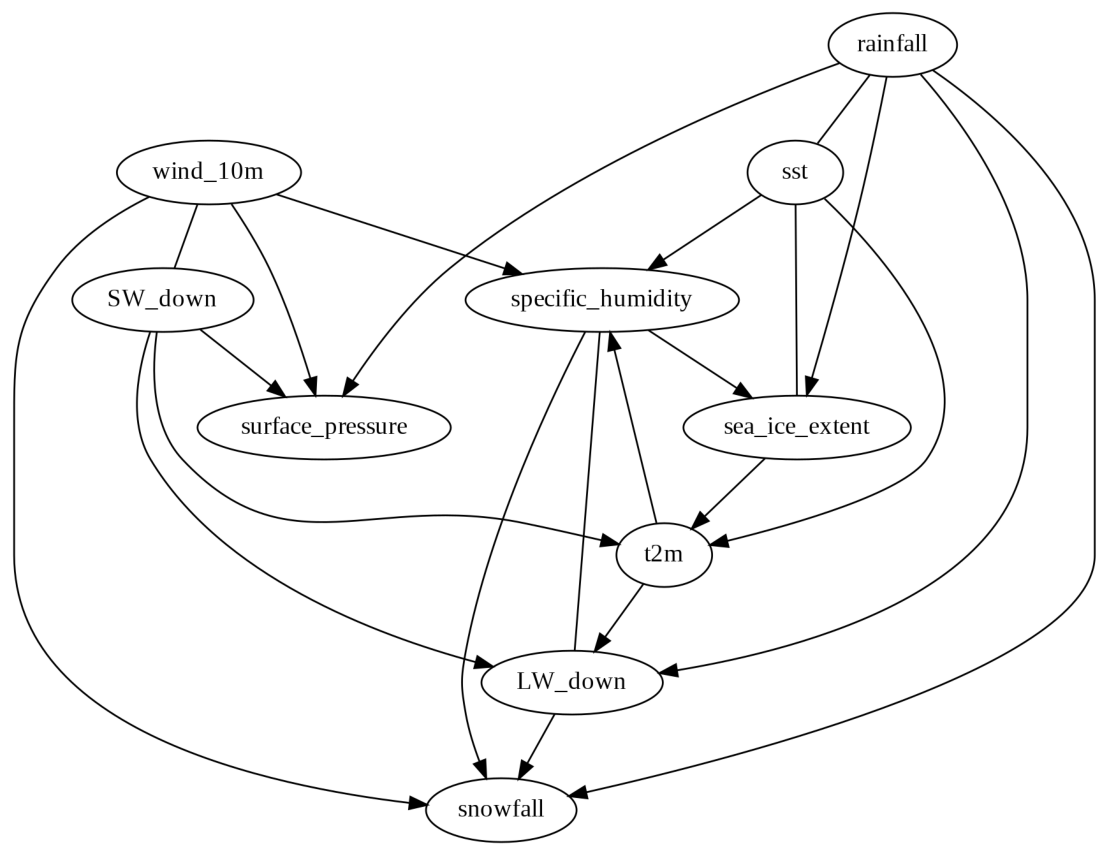

In [58]:
cg = pc(data1, 0.05, fisherz, True, 0, -1)

# visualization using pydot
cols = df1_norm.columns
cg.draw_pydot_graph(labels=cols)

###From GES

[[ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 -1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
[[ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0 -1  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0 -1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0 -1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
[[ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0 -1  0  0  0  0  0  0  0]
 [ 0 -1  0  0  0  0  0 -1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 -1]
 [ 0  0 -1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0]]
[[ 0  0

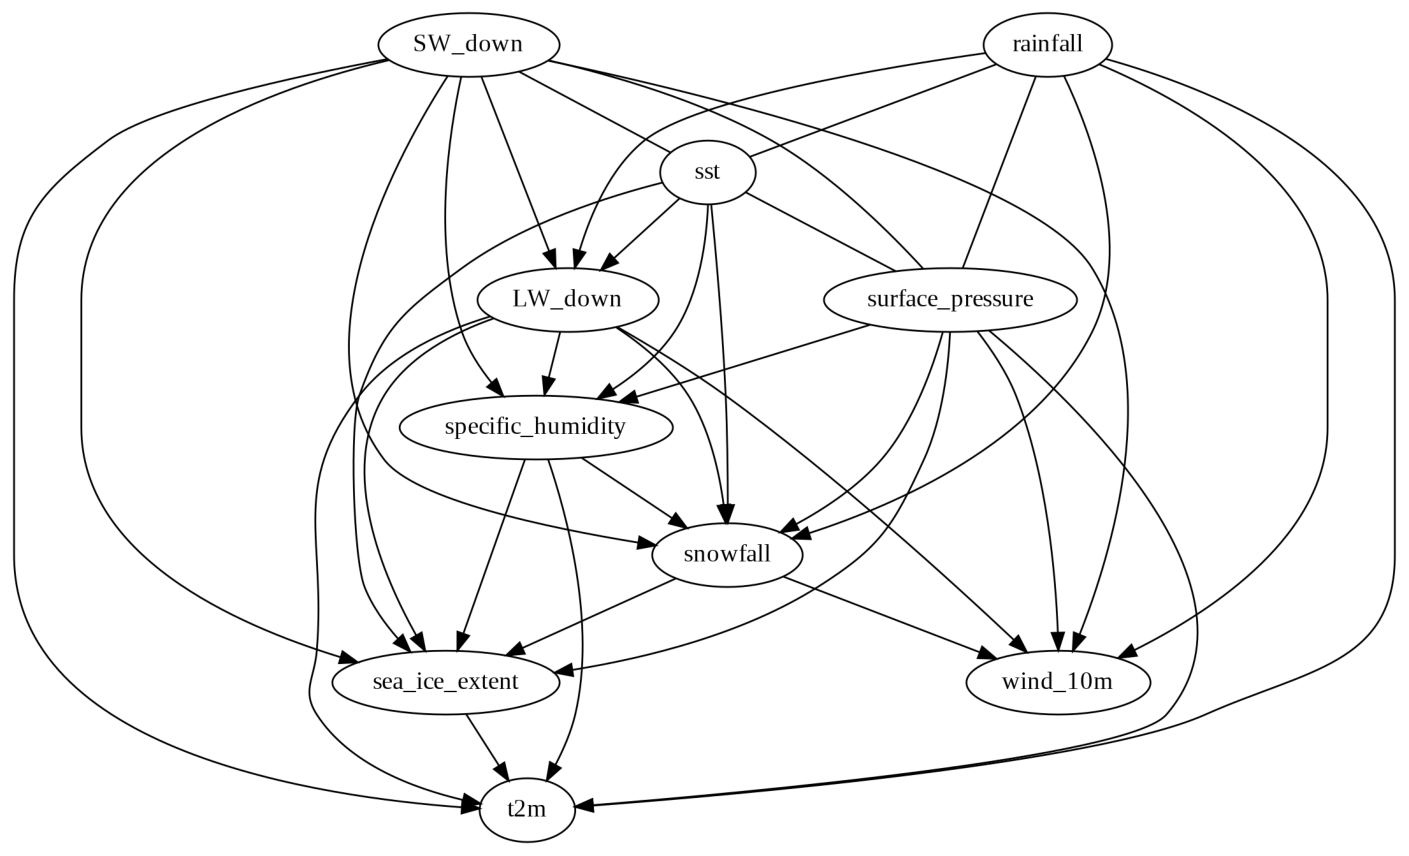

In [59]:

Record = ges(data1, score_func = "local_score_BIC", maxP = None, parameters = None)

# Visualization using pydot
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io



pyd = GraphUtils.to_pydot(Record['G'], labels=cols)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

#*Granger Causality Test*#

Linear regression might indicate a strong relationship between two or more variables, but these variables may be totally unrelated in reality. Predictions fail when it comes to domain knowledge, this scenario is known as spurious regression.

There is a strong relationship between chicken consumption and crude oil exports in the below graph even though they are unrelated.

A prerequisite for performing the Granger Causality test is that the data need to be stationary i.e it should have a constant mean, constant variance, and no seasonal component. Transform the non-stationary data to stationary data by differencing it, either first-order or second-order differencing. Do not proceed with the Granger causality test if the data is not stationary after second-order differencing.

Let us consider three variables Xt , Yt , and Wt preset in time series data

Forecast Xt+1 based on past values Xt and Yt

Let's assume from our causal graph that the past values of Y contain information for forecasting Xt+1. Yt is said to “Granger cause” Xt+1 provided Yt occurs before Xt+1 and it contains data for forecasting Xt+1

If Yt causes Xt, then Y must precede X which implies:
*   Lagged values of Y should be significantly related to X.
*   Lagged values of X should not be significantly related to Y.




In [60]:
#Nice resource: https://causal-learn.readthedocs.io/en/latest/search_methods_index/Granger%20causality/LinearGranger.html
#https://www.analyticsvidhya.com/blog/2021/08/granger-causality-in-time-series-explained-using-chicken-and-egg-problem/

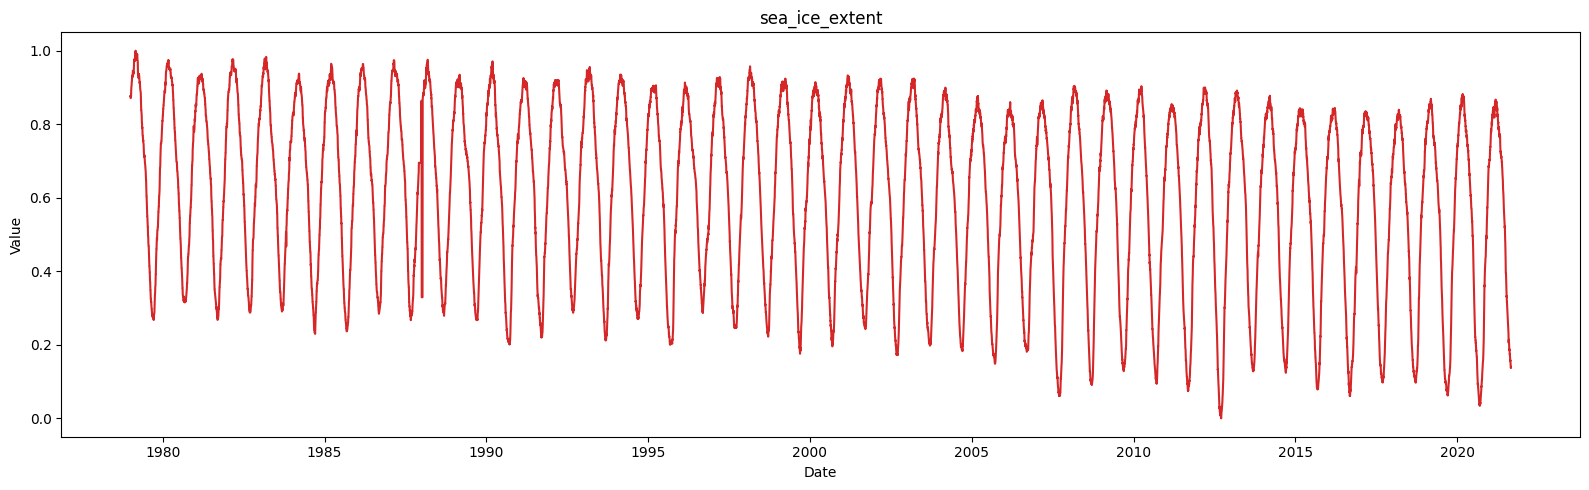

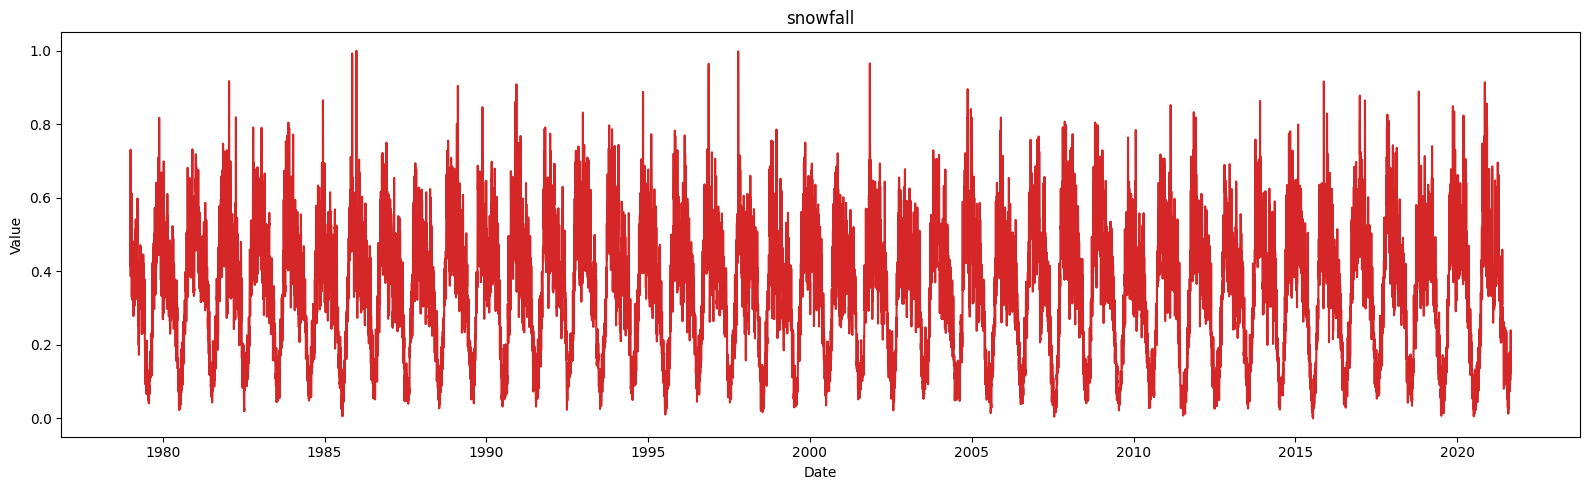

In [61]:
df = df1_norm[["sea_ice_extent", "snowfall"]]

# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
plot_df(df, x=df.index, y=df.sea_ice_extent, title='sea_ice_extent')
plot_df(df, x=df.index, y=df.snowfall, title='snowfall')

Testing stationarity for variable sea ice content

In [62]:
from statsmodels.tsa.stattools import adfuller
result_sea = adfuller(df['sea_ice_extent'])
print(f'Test Statistics: {result_sea[0]}')
print(f'p-value: {result_sea[1]}')
print(f'critical_values: {result_sea[4]}')

if result_sea[1] > 0.05:
  print("Series is not stationary")
else:
  print("Series is stationary")

Test Statistics: -18.947518496536425
p-value: 0.0
critical_values: {'1%': -3.4307708468206393, '5%': -2.861725996564341, '10%': -2.566869001399376}
Series is stationary


Testing stationarity for variable snowfall

In [63]:
result_snow = adfuller(df['snowfall'])

print(f'Test Statistics: {result_snow[0]}')
print(f'p-value: {result_snow[1]}')
print(f'critical_values: {result_snow[4]}')

if result_snow[1] > 0.05:
  print("Series is not stationary")
else:
  print("Series is stationary")

Test Statistics: -11.738512046950849
p-value: 1.2903655039930702e-21
critical_values: {'1%': -3.430770873906635, '5%': -2.8617260085343617, '10%': -2.5668690077708707}
Series is stationary


In [64]:
df_transformed = df.diff().dropna()
df = df.iloc[1:]
print(df.shape)
df_transformed.shape

(15583, 2)


(15583, 2)

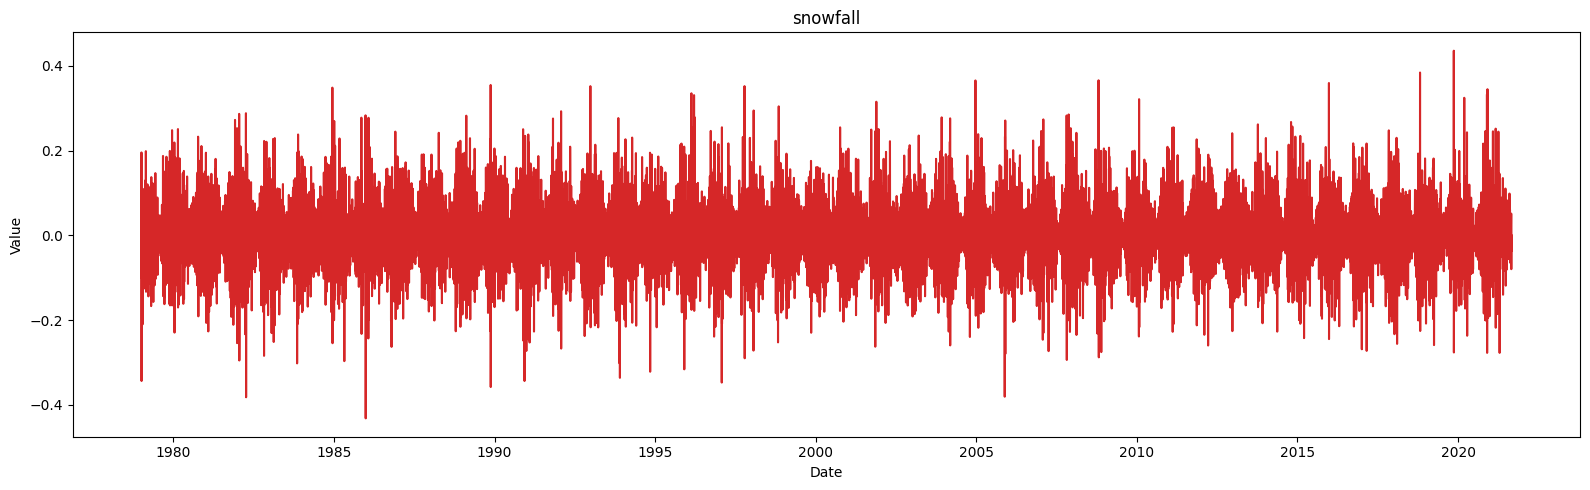

In [65]:
#plot_df(df_transformed, x=df.index, y=df_transformed.sea_ice_extent, title='sea_ice_extent') 
plot_df(df_transformed, x=df.index, y=df_transformed.snowfall, title='snowfall')

In [66]:
result_tsea = adfuller(df_transformed['sea_ice_extent'])
print(f'Test Statistics: {result_tsea[0]}')
print(f'p-value: {result_tsea[1]}')
print(f'critical_values: {result_tsea[4]}')

Test Statistics: -9.211862736805053
p-value: 1.8783543016650005e-15
critical_values: {'1%': -3.430770657316245, '5%': -2.8617259128173154, '10%': -2.566868956821863}


In [67]:
if result_tsea[1] > 0.05:
  print("Series is not stationary")
else:
  print("Series is stationary")

Series is stationary


Testing stationarity for variable snowfall

In [68]:
result_tsnow = adfuller(df_transformed['snowfall'])

print(f'Test Statistics: {result_tsnow[0]}')
print(f'p-value: {result_tsnow[1]}')
print(f'critical_values: {result_tsnow[4]}')

if result_tsnow[1] > 0.05:
  print("Series is not stationary")
else:
  print("Series is stationary")

Test Statistics: -17.27173112446898
p-value: 5.85512140835217e-30
critical_values: {'1%': -3.4307709009961167, '5%': -2.8617260205059227, '10%': -2.566869014143186}
Series is stationary


In [85]:
res = grangercausalitytests(df3[['sea_ice_extent', 'snowfall']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1224.9068, p=0.0000  , df_denom=2431, df_num=1
ssr based chi2 test:   chi2=1226.4184, p=0.0000  , df=1
likelihood ratio test: chi2=993.1729, p=0.0000  , df=1
parameter F test:         F=1224.9068, p=0.0000  , df_denom=2431, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=215.5445, p=0.0000  , df_denom=2428, df_num=2
ssr based chi2 test:   chi2=431.9767, p=0.0000  , df=2
likelihood ratio test: chi2=397.6377, p=0.0000  , df=2
parameter F test:         F=215.5445, p=0.0000  , df_denom=2428, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=105.4745, p=0.0000  , df_denom=2425, df_num=3
ssr based chi2 test:   chi2=317.3370, p=0.0000  , df=3
likelihood ratio test: chi2=298.2746, p=0.0000  , df=3
parameter F test:         F=105.4745, p=0.0000  , df_denom=2425, df_num=3


In [86]:
res = grangercausalitytests(df3[['snowfall', 'sea_ice_extent']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.0762  , p=0.0079  , df_denom=2431, df_num=1
ssr based chi2 test:   chi2=7.0849  , p=0.0078  , df=1
likelihood ratio test: chi2=7.0746  , p=0.0078  , df=1
parameter F test:         F=7.0762  , p=0.0079  , df_denom=2431, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=57.6168 , p=0.0000  , df_denom=2428, df_num=2
ssr based chi2 test:   chi2=115.4708, p=0.0000  , df=2
likelihood ratio test: chi2=112.8144, p=0.0000  , df=2
parameter F test:         F=57.6168 , p=0.0000  , df_denom=2428, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=30.0380 , p=0.0000  , df_denom=2425, df_num=3
ssr based chi2 test:   chi2=90.3742 , p=0.0000  , df=3
likelihood ratio test: chi2=88.7355 , p=0.0000  , df=3
parameter F test:         F=30.0380 , p=0.0000  , df_denom=2425, df_num=3


In [87]:
res = grangercausalitytests(df3[['sea_ice_extent', 'wind_10m']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=442.8904, p=0.0000  , df_denom=2431, df_num=1
ssr based chi2 test:   chi2=443.4370, p=0.0000  , df=1
likelihood ratio test: chi2=407.3639, p=0.0000  , df=1
parameter F test:         F=442.8904, p=0.0000  , df_denom=2431, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=87.0096 , p=0.0000  , df_denom=2428, df_num=2
ssr based chi2 test:   chi2=174.3776, p=0.0000  , df=2
likelihood ratio test: chi2=168.4121, p=0.0000  , df=2
parameter F test:         F=87.0096 , p=0.0000  , df_denom=2428, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=47.2497 , p=0.0000  , df_denom=2425, df_num=3
ssr based chi2 test:   chi2=142.1582, p=0.0000  , df=3
likelihood ratio test: chi2=138.1586, p=0.0000  , df=3
parameter F test:         F=47.2497 , p=0.0000  , df_denom=2425, df_num=3


In [88]:
res = grangercausalitytests(df3[['wind_10m', 'sea_ice_extent']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.0765 , p=0.0015  , df_denom=2431, df_num=1
ssr based chi2 test:   chi2=10.0889 , p=0.0015  , df=1
likelihood ratio test: chi2=10.0681 , p=0.0015  , df=1
parameter F test:         F=10.0765 , p=0.0015  , df_denom=2431, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=82.8805 , p=0.0000  , df_denom=2428, df_num=2
ssr based chi2 test:   chi2=166.1024, p=0.0000  , df=2
likelihood ratio test: chi2=160.6780, p=0.0000  , df=2
parameter F test:         F=82.8805 , p=0.0000  , df_denom=2428, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=43.2034 , p=0.0000  , df_denom=2425, df_num=3
ssr based chi2 test:   chi2=129.9844, p=0.0000  , df=3
likelihood ratio test: chi2=126.6298, p=0.0000  , df=3
parameter F test:         F=43.2034 , p=0.0000  , df_denom=2425, df_num=3


In [89]:
res = grangercausalitytests(df3[['sea_ice_extent', 'specific_humidity']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2171.3616, p=0.0000  , df_denom=2431, df_num=1
ssr based chi2 test:   chi2=2174.0412, p=0.0000  , df=1
likelihood ratio test: chi2=1553.5416, p=0.0000  , df=1
parameter F test:         F=2171.3616, p=0.0000  , df_denom=2431, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=384.4176, p=0.0000  , df_denom=2428, df_num=2
ssr based chi2 test:   chi2=770.4186, p=0.0000  , df=2
likelihood ratio test: chi2=669.3024, p=0.0000  , df=2
parameter F test:         F=384.4176, p=0.0000  , df_denom=2428, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=189.0249, p=0.0000  , df_denom=2425, df_num=3
ssr based chi2 test:   chi2=568.7118, p=0.0000  , df=3
likelihood ratio test: chi2=511.0497, p=0.0000  , df=3
parameter F test:         F=189.0249, p=0.0000  , df_denom=2425, df_num=3


In [90]:
res = grangercausalitytests(df3[['specific_humidity', 'sea_ice_extent']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=408.4861, p=0.0000  , df_denom=2431, df_num=1
ssr based chi2 test:   chi2=408.9902, p=0.0000  , df=1
likelihood ratio test: chi2=378.0498, p=0.0000  , df=1
parameter F test:         F=408.4861, p=0.0000  , df_denom=2431, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=77.1102 , p=0.0000  , df_denom=2428, df_num=2
ssr based chi2 test:   chi2=154.5379, p=0.0000  , df=2
likelihood ratio test: chi2=149.8284, p=0.0000  , df=2
parameter F test:         F=77.1102 , p=0.0000  , df_denom=2428, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=73.9541 , p=0.0000  , df_denom=2425, df_num=3
ssr based chi2 test:   chi2=222.5027, p=0.0000  , df=3
likelihood ratio test: chi2=212.9054, p=0.0000  , df=3
parameter F test:         F=73.9541 , p=0.0000  , df_denom=2425, df_num=3


In [91]:
res = grangercausalitytests(df3[['sea_ice_extent', 'LW_down']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1946.0241, p=0.0000  , df_denom=2431, df_num=1
ssr based chi2 test:   chi2=1948.4256, p=0.0000  , df=1
likelihood ratio test: chi2=1431.3535, p=0.0000  , df=1
parameter F test:         F=1946.0241, p=0.0000  , df_denom=2431, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=335.1160, p=0.0000  , df_denom=2428, df_num=2
ssr based chi2 test:   chi2=671.6123, p=0.0000  , df=2
likelihood ratio test: chi2=593.0773, p=0.0000  , df=2
parameter F test:         F=335.1160, p=0.0000  , df_denom=2428, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=160.6693, p=0.0000  , df_denom=2425, df_num=3
ssr based chi2 test:   chi2=483.3993, p=0.0000  , df=3
likelihood ratio test: chi2=440.9042, p=0.0000  , df=3
parameter F test:         F=160.6693, p=0.0000  , df_denom=2425, df_num=3


In [92]:
res = grangercausalitytests(df3[['LW_down', 'sea_ice_extent']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=266.5612, p=0.0000  , df_denom=2431, df_num=1
ssr based chi2 test:   chi2=266.8902, p=0.0000  , df=1
likelihood ratio test: chi2=253.2466, p=0.0000  , df=1
parameter F test:         F=266.5612, p=0.0000  , df_denom=2431, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=63.0382 , p=0.0000  , df_denom=2428, df_num=2
ssr based chi2 test:   chi2=126.3359, p=0.0000  , df=2
likelihood ratio test: chi2=123.1652, p=0.0000  , df=2
parameter F test:         F=63.0382 , p=0.0000  , df_denom=2428, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=70.6750 , p=0.0000  , df_denom=2425, df_num=3
ssr based chi2 test:   chi2=212.6370, p=0.0000  , df=3
likelihood ratio test: chi2=203.8499, p=0.0000  , df=3
parameter F test:         F=70.6750 , p=0.0000  , df_denom=2425, df_num=3


In [93]:
res = grangercausalitytests(df3[['sea_ice_extent', 'snowfall']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1224.9068, p=0.0000  , df_denom=2431, df_num=1
ssr based chi2 test:   chi2=1226.4184, p=0.0000  , df=1
likelihood ratio test: chi2=993.1729, p=0.0000  , df=1
parameter F test:         F=1224.9068, p=0.0000  , df_denom=2431, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=215.5445, p=0.0000  , df_denom=2428, df_num=2
ssr based chi2 test:   chi2=431.9767, p=0.0000  , df=2
likelihood ratio test: chi2=397.6377, p=0.0000  , df=2
parameter F test:         F=215.5445, p=0.0000  , df_denom=2428, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=105.4745, p=0.0000  , df_denom=2425, df_num=3
ssr based chi2 test:   chi2=317.3370, p=0.0000  , df=3
likelihood ratio test: chi2=298.2746, p=0.0000  , df=3
parameter F test:         F=105.4745, p=0.0000  , df_denom=2425, df_num=3


In [94]:
res = grangercausalitytests(df3[['snowfall', 'sea_ice_extent']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.0762  , p=0.0079  , df_denom=2431, df_num=1
ssr based chi2 test:   chi2=7.0849  , p=0.0078  , df=1
likelihood ratio test: chi2=7.0746  , p=0.0078  , df=1
parameter F test:         F=7.0762  , p=0.0079  , df_denom=2431, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=57.6168 , p=0.0000  , df_denom=2428, df_num=2
ssr based chi2 test:   chi2=115.4708, p=0.0000  , df=2
likelihood ratio test: chi2=112.8144, p=0.0000  , df=2
parameter F test:         F=57.6168 , p=0.0000  , df_denom=2428, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=30.0380 , p=0.0000  , df_denom=2425, df_num=3
ssr based chi2 test:   chi2=90.3742 , p=0.0000  , df=3
likelihood ratio test: chi2=88.7355 , p=0.0000  , df=3
parameter F test:         F=30.0380 , p=0.0000  , df_denom=2425, df_num=3


In [95]:
res = grangercausalitytests(df3[['sea_ice_extent', 'SW_down']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1598.7240, p=0.0000  , df_denom=2431, df_num=1
ssr based chi2 test:   chi2=1600.6969, p=0.0000  , df=1
likelihood ratio test: chi2=1230.1319, p=0.0000  , df=1
parameter F test:         F=1598.7240, p=0.0000  , df_denom=2431, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=260.0356, p=0.0000  , df_denom=2428, df_num=2
ssr based chi2 test:   chi2=521.1422, p=0.0000  , df=2
likelihood ratio test: chi2=472.2045, p=0.0000  , df=2
parameter F test:         F=260.0356, p=0.0000  , df_denom=2428, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=117.9206, p=0.0000  , df_denom=2425, df_num=3
ssr based chi2 test:   chi2=354.7830, p=0.0000  , df=3
likelihood ratio test: chi2=331.1750, p=0.0000  , df=3
parameter F test:         F=117.9206, p=0.0000  , df_denom=2425, df_num=3


In [96]:
res = grangercausalitytests(df3[['SW_down', 'sea_ice_extent']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=595.5999, p=0.0000  , df_denom=2431, df_num=1
ssr based chi2 test:   chi2=596.3349, p=0.0000  , df=1
likelihood ratio test: chi2=533.3798, p=0.0000  , df=1
parameter F test:         F=595.5999, p=0.0000  , df_denom=2431, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=204.9799, p=0.0000  , df_denom=2428, df_num=2
ssr based chi2 test:   chi2=410.8041, p=0.0000  , df=2
likelihood ratio test: chi2=379.5907, p=0.0000  , df=2
parameter F test:         F=204.9799, p=0.0000  , df_denom=2428, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=125.8408, p=0.0000  , df_denom=2425, df_num=3
ssr based chi2 test:   chi2=378.6120, p=0.0000  , df=3
likelihood ratio test: chi2=351.8820, p=0.0000  , df=3
parameter F test:         F=125.8408, p=0.0000  , df_denom=2425, df_num=3


In [97]:
res = grangercausalitytests(df3[['sea_ice_extent', 'rainfall']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=56.4758 , p=0.0000  , df_denom=2431, df_num=1
ssr based chi2 test:   chi2=56.5455 , p=0.0000  , df=1
likelihood ratio test: chi2=55.8986 , p=0.0000  , df=1
parameter F test:         F=56.4758 , p=0.0000  , df_denom=2431, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=23.3256 , p=0.0000  , df_denom=2428, df_num=2
ssr based chi2 test:   chi2=46.7473 , p=0.0000  , df=2
likelihood ratio test: chi2=46.3038 , p=0.0000  , df=2
parameter F test:         F=23.3256 , p=0.0000  , df_denom=2428, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=15.5150 , p=0.0000  , df_denom=2425, df_num=3
ssr based chi2 test:   chi2=46.6795 , p=0.0000  , df=3
likelihood ratio test: chi2=46.2372 , p=0.0000  , df=3
parameter F test:         F=15.5150 , p=0.0000  , df_denom=2425, df_num=3


In [98]:
res = grangercausalitytests(df3[['rainfall', 'sea_ice_extent']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=292.4344, p=0.0000  , df_denom=2431, df_num=1
ssr based chi2 test:   chi2=292.7953, p=0.0000  , df=1
likelihood ratio test: chi2=276.4806, p=0.0000  , df=1
parameter F test:         F=292.4344, p=0.0000  , df_denom=2431, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=144.3670, p=0.0000  , df_denom=2428, df_num=2
ssr based chi2 test:   chi2=289.3285, p=0.0000  , df=2
likelihood ratio test: chi2=273.3780, p=0.0000  , df=2
parameter F test:         F=144.3670, p=0.0000  , df_denom=2428, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=73.1121 , p=0.0000  , df_denom=2425, df_num=3
ssr based chi2 test:   chi2=219.9693, p=0.0000  , df=3
likelihood ratio test: chi2=210.5833, p=0.0000  , df=3
parameter F test:         F=73.1121 , p=0.0000  , df_denom=2425, df_num=3


In [99]:
res = grangercausalitytests(df3[['sea_ice_extent', 'sst']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1329.8526, p=0.0000  , df_denom=2431, df_num=1
ssr based chi2 test:   chi2=1331.4937, p=0.0000  , df=1
likelihood ratio test: chi2=1062.0589, p=0.0000  , df=1
parameter F test:         F=1329.8526, p=0.0000  , df_denom=2431, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=257.1141, p=0.0000  , df_denom=2428, df_num=2
ssr based chi2 test:   chi2=515.2872, p=0.0000  , df=2
likelihood ratio test: chi2=467.3777, p=0.0000  , df=2
parameter F test:         F=257.1141, p=0.0000  , df_denom=2428, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=124.7803, p=0.0000  , df_denom=2425, df_num=3
ssr based chi2 test:   chi2=375.4215, p=0.0000  , df=3
likelihood ratio test: chi2=349.1196, p=0.0000  , df=3
parameter F test:         F=124.7803, p=0.0000  , df_denom=2425, df_num=3


In [100]:
res = grangercausalitytests(df3[['sst', 'sea_ice_extent']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=850.2592, p=0.0000  , df_denom=2431, df_num=1
ssr based chi2 test:   chi2=851.3085, p=0.0000  , df=1
likelihood ratio test: chi2=730.0164, p=0.0000  , df=1
parameter F test:         F=850.2592, p=0.0000  , df_denom=2431, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=144.4536, p=0.0000  , df_denom=2428, df_num=2
ssr based chi2 test:   chi2=289.5021, p=0.0000  , df=2
likelihood ratio test: chi2=273.5331, p=0.0000  , df=2
parameter F test:         F=144.4536, p=0.0000  , df_denom=2428, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=58.4722 , p=0.0000  , df_denom=2425, df_num=3
ssr based chi2 test:   chi2=175.9229, p=0.0000  , df=3
likelihood ratio test: chi2=169.8511, p=0.0000  , df=3
parameter F test:         F=58.4722 , p=0.0000  , df_denom=2425, df_num=3


In [101]:
res = grangercausalitytests(df3[['sea_ice_extent', 't2m']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1783.0472, p=0.0000  , df_denom=2431, df_num=1
ssr based chi2 test:   chi2=1785.2476, p=0.0000  , df=1
likelihood ratio test: chi2=1338.9941, p=0.0000  , df=1
parameter F test:         F=1783.0472, p=0.0000  , df_denom=2431, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=299.1977, p=0.0000  , df_denom=2428, df_num=2
ssr based chi2 test:   chi2=599.6278, p=0.0000  , df=2
likelihood ratio test: chi2=536.0007, p=0.0000  , df=2
parameter F test:         F=299.1977, p=0.0000  , df_denom=2428, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=141.5060, p=0.0000  , df_denom=2425, df_num=3
ssr based chi2 test:   chi2=425.7435, p=0.0000  , df=3
likelihood ratio test: chi2=392.3263, p=0.0000  , df=3
parameter F test:         F=141.5060, p=0.0000  , df_denom=2425, df_num=3


In [102]:
res = grangercausalitytests(df3[['t2m', 'sea_ice_extent']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=518.3236, p=0.0000  , df_denom=2431, df_num=1
ssr based chi2 test:   chi2=518.9632, p=0.0000  , df=1
likelihood ratio test: chi2=470.4269, p=0.0000  , df=1
parameter F test:         F=518.3236, p=0.0000  , df_denom=2431, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=76.3330 , p=0.0000  , df_denom=2428, df_num=2
ssr based chi2 test:   chi2=152.9804, p=0.0000  , df=2
likelihood ratio test: chi2=148.3634, p=0.0000  , df=2
parameter F test:         F=76.3330 , p=0.0000  , df_denom=2428, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=68.4591 , p=0.0000  , df_denom=2425, df_num=3
ssr based chi2 test:   chi2=205.9703, p=0.0000  , df=3
likelihood ratio test: chi2=197.7115, p=0.0000  , df=3
parameter F test:         F=68.4591 , p=0.0000  , df_denom=2425, df_num=3


In [105]:
res = grangercausalitytests(df3[['sea_ice_extent', 'surface_pressure']], maxlag=9)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=38.2069 , p=0.0000  , df_denom=2431, df_num=1
ssr based chi2 test:   chi2=38.2540 , p=0.0000  , df=1
likelihood ratio test: chi2=37.9565 , p=0.0000  , df=1
parameter F test:         F=38.2069 , p=0.0000  , df_denom=2431, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.8618  , p=0.0212  , df_denom=2428, df_num=2
ssr based chi2 test:   chi2=7.7394  , p=0.0209  , df=2
likelihood ratio test: chi2=7.7271  , p=0.0210  , df=2
parameter F test:         F=3.8618  , p=0.0212  , df_denom=2428, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1354  , p=0.0937  , df_denom=2425, df_num=3
ssr based chi2 test:   chi2=6.4247  , p=0.0927  , df=3
likelihood ratio test: chi2=6.4162  , p=0.0930  , df=3
parameter F test:         F=2.1354  , p=0.0937  , df_denom=2425, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2285  , p=0.

In [106]:
res = grangercausalitytests(df3[['surface_pressure', 'sea_ice_extent']], maxlag=10)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5833  , p=0.4451  , df_denom=2431, df_num=1
ssr based chi2 test:   chi2=0.5840  , p=0.4447  , df=1
likelihood ratio test: chi2=0.5840  , p=0.4448  , df=1
parameter F test:         F=0.5833  , p=0.4451  , df_denom=2431, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.7434  , p=0.0088  , df_denom=2428, df_num=2
ssr based chi2 test:   chi2=9.5063  , p=0.0086  , df=2
likelihood ratio test: chi2=9.4878  , p=0.0087  , df=2
parameter F test:         F=4.7434  , p=0.0088  , df_denom=2428, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.7313  , p=0.0424  , df_denom=2425, df_num=3
ssr based chi2 test:   chi2=8.2176  , p=0.0417  , df=3
likelihood ratio test: chi2=8.2037  , p=0.0420  , df=3
parameter F test:         F=2.7313  , p=0.0424  , df_denom=2425, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.2482  , p=0.

In [71]:
# for i in df1_norm.columns:
#   print(i)

In [72]:
# for i in df1_norm.columns:
#   for j in df1_norm.columns:
#     if i == j:
#       res = grangercausalitytests(df1_norm[[i, j]], maxlag=4)
#     print("The Granger Causality results for", i, "and ", j)
#   print(res)

#*VAR-LiNGAM Algorithm*#

#*PCMCI Algorithm*#

#*CCM*#

##snowfall and sea_ice_extent in the artic regions##	
We investigate the bi-directional effects of the quantity of snow fall on the content of sea ice for the period between 1979 and 2021. 

Do we expect these two to be causally linked?

In [73]:
df1_norm['date'] = df1_norm.index

In [74]:
df1_norm.columns

Index(['wind_10m', 'specific_humidity', 'LW_down', 'SW_down', 'rainfall',
       'snowfall', 'sst', 't2m', 'surface_pressure', 'sea_ice_extent', 'date'],
      dtype='object')

In [75]:
df3 = df1_norm.loc['2015-01-01':'2021-08-31']

In [107]:
# #df['date'] = range(1999, 2010)
# make_plots(df, 'date', 'sea_ice_extent', 'snowfall')
## Helper plotting function
def make_plots(df, dt_name, val1_name, val2_name):
    # drop nulls
    df = df[[dt_name, val1_name, val2_name]].dropna()
    
    # smoothen
    date_smooth = np.linspace(df[dt_name].min(), df[dt_name].max(), 100) 
    spl = make_interp_spline(df[dt_name], df[val1_name], k=2)
    val1 = spl(date_smooth)
    spl = make_interp_spline(df[dt_name], df[val2_name], k=2)
    val2 = spl(date_smooth)    
    r, p = np.round(pearsonr(df[val1_name], df[val2_name]), 4)
    
    # plot
    f, ax = plt.subplots(figsize=(12, 4))
    ax.plot(date_smooth, val1, )
    ax = df.plot(x=dt_name, y=val1_name, marker='', c='b', linestyle='', legend=False, ax=ax)
    ax.set_ylabel(val1_name)
    ax2 = ax.twinx()
    ax2.plot(date_smooth, val2, c='r')
    df.plot(x=dt_name, y=val2_name, marker='', c='r', linestyle='', legend=False, ax=ax2)
    ax2.set_ylabel(val2_name)    
    ax.figure.legend()        
    plt.title(f"{val1_name} and {val2_name}, correlation coefficient: {r}", size=16)
    plt.tight_layout()
    plt.show()

In [111]:
df = df3[['snowfall', 'sea_ice_extent']]
df['date'] = df.index
make_plots(df, df.date, df.snowfall, df.sea_ice_extent)

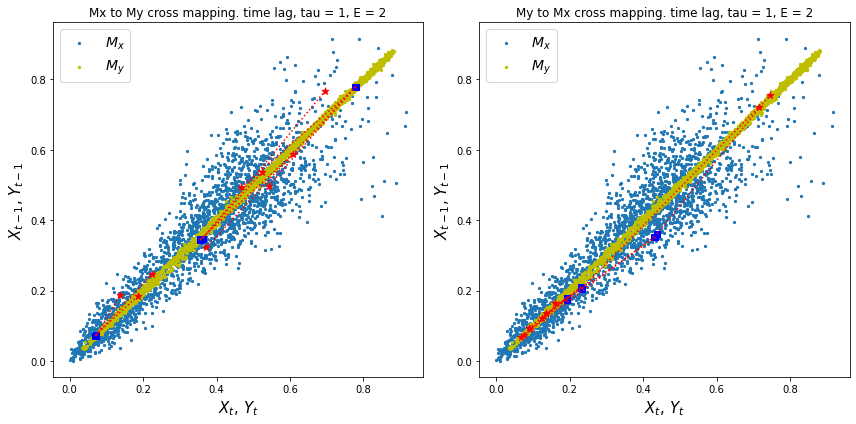

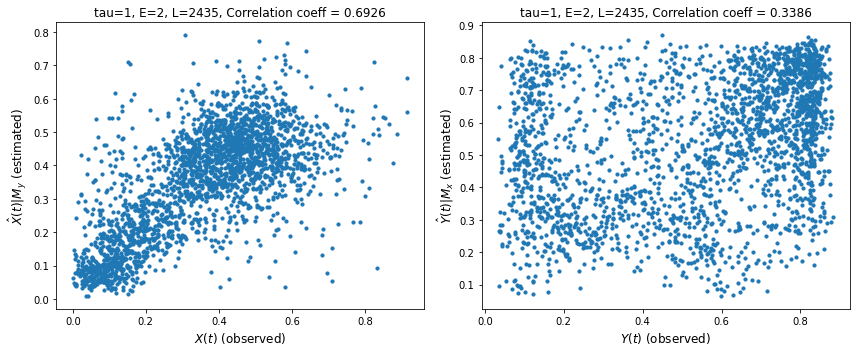

snowfall -> sea_ice_extent r 0.69 p value 0.0
sea_ice_extent -> snowfall r 0.34 p value 0.0


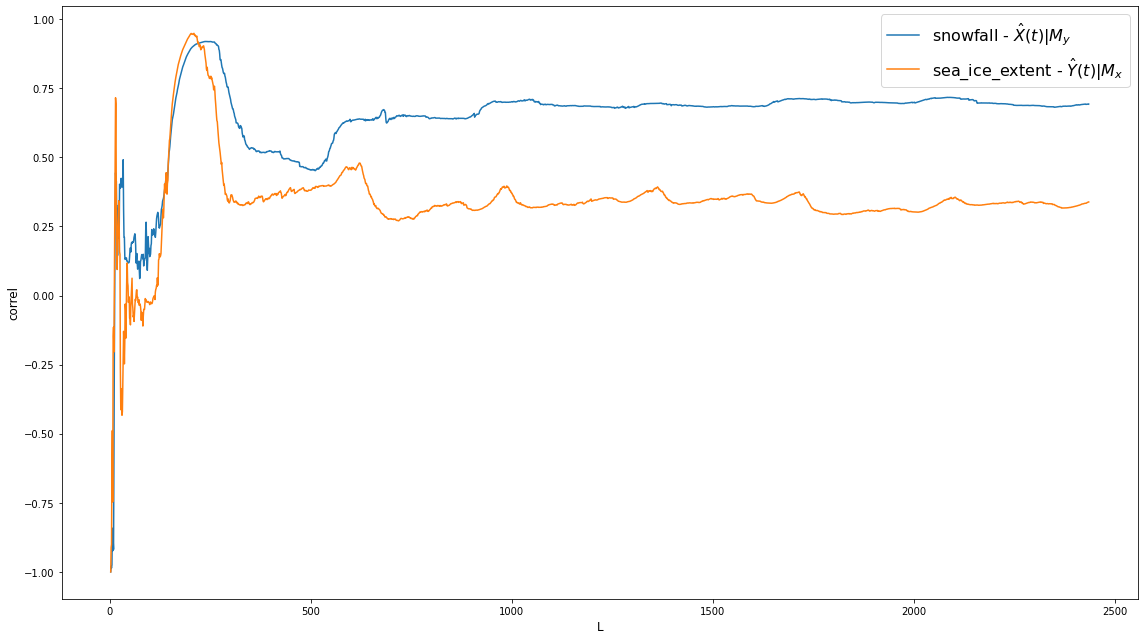

In [78]:
# Visualize simple shadow manifolds Mx and My for different tau
# We visualize Cross-Mapping

np.random.seed(1) # we fix the seed when randomly choosing cross mapping points
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = df.shape[0] # length of time period to consider

Y = df['sea_ice_extent'].values
X = df['snowfall'].values


ccm1 = ccm(X, Y, tau, E, L)

# causality X -> Y
# returns: (correlation ("strength" of causality), p-value(significance))
ccm1.causality()


# visualize sample cross mapping
ccm1.visualize_cross_mapping()

# Looking at "convergence"
L_range = range(3, L+1, 1) # L values to test
Xhat_My, Yhat_Mx = [], [] # correlation list
for L in L_range: 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0])    
    
# Check correlation plot
ccm1.plot_ccm_correls() 

# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(16,9))
plt.plot(L_range, Xhat_My, label='snowfall - $\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, label='sea_ice_extent - $\hat{Y}(t)|M_x$')
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 16})  

print('snowfall -> sea_ice_extent r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY.causality()[1], 2))
print('sea_ice_extent -> snowfall r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX.causality()[1], 2))

##wind_10m vs sea_ice_extent##

###Here we investigate the effects of wind speed at 10m above sea level to the content of sea ice###

In [79]:
df = df3[['wind_10m', 'sea_ice_extent']]
df['date'] = df.index
make_plots(df, df.index, 'wind_10m', 'sea_ice_extent')

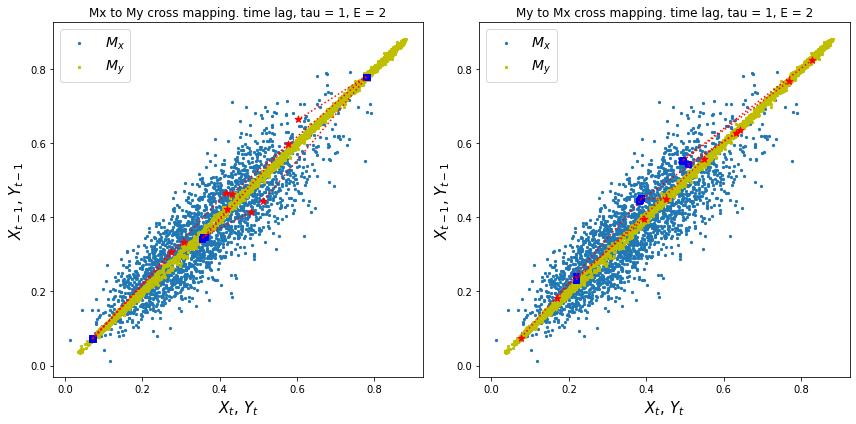

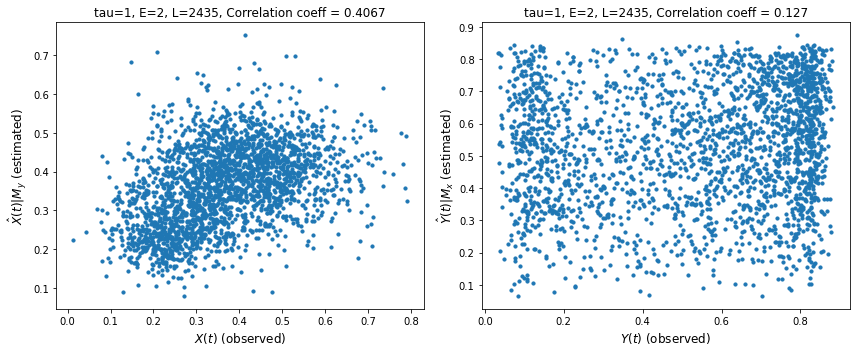

wind_10m -> sea_ice_extent r 0.41 p value 0.0
sea_ice_extent -> wind_10m r 0.13 p value 0.0


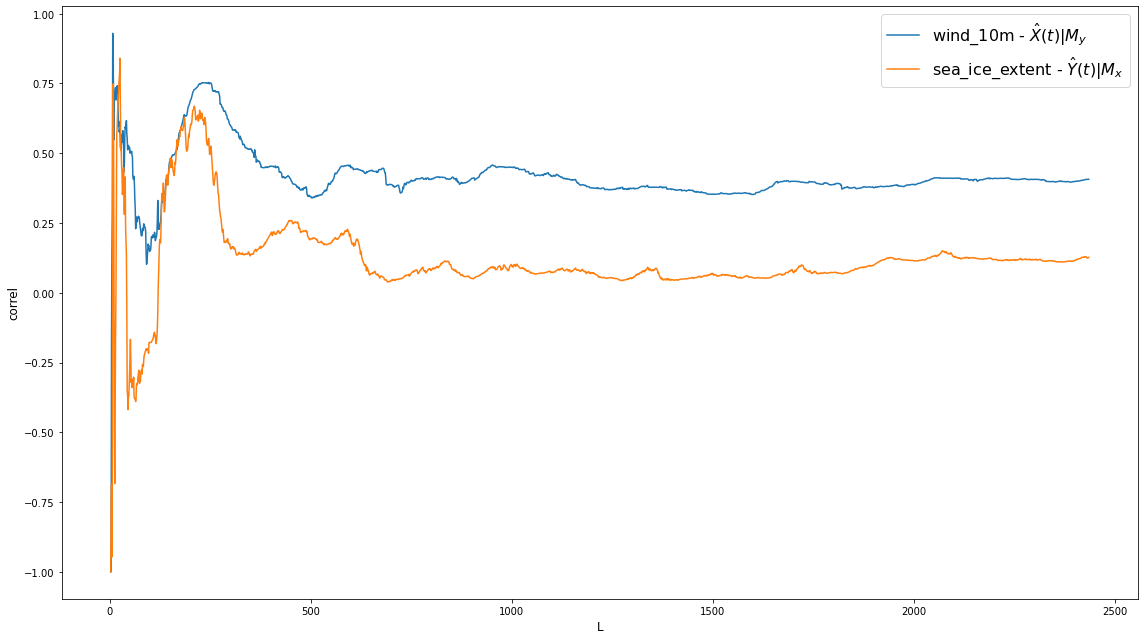

In [80]:
# Visualize simple shadow manifolds Mx and My for different tau
# We visualize Cross-Mapping

np.random.seed(1) # we fix the seed when randomly choosing cross mapping points
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = df.shape[0] # length of time period to consider

Y = df['sea_ice_extent'].values
X = df['wind_10m'].values


ccm1 = ccm(X, Y, tau, E, L)

# causality X -> Y
# returns: (correlation ("strength" of causality), p-value(significance))
ccm1.causality()


# visualize sample cross mapping
ccm1.visualize_cross_mapping()

# Looking at "convergence"
L_range = range(3, L+1, 1) # L values to test
Xhat_My, Yhat_Mx = [], [] # correlation list
for L in L_range: 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0])    
    
# Check correlation plot
ccm1.plot_ccm_correls() 

# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(16,9))
plt.plot(L_range, Xhat_My, label='wind_10m - $\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, label='sea_ice_extent - $\hat{Y}(t)|M_x$')
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 16})  

print('wind_10m -> sea_ice_extent r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY.causality()[1], 2))
print('sea_ice_extent -> wind_10m r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX.causality()[1], 2))

#**sw_down vs sea_ice_extent**#

In [81]:
df = df3[['SW_down', 'sea_ice_extent']]
df['date'] = df.index
make_plots(df, 'date', 'SW_down', 'sea_ice_extent')

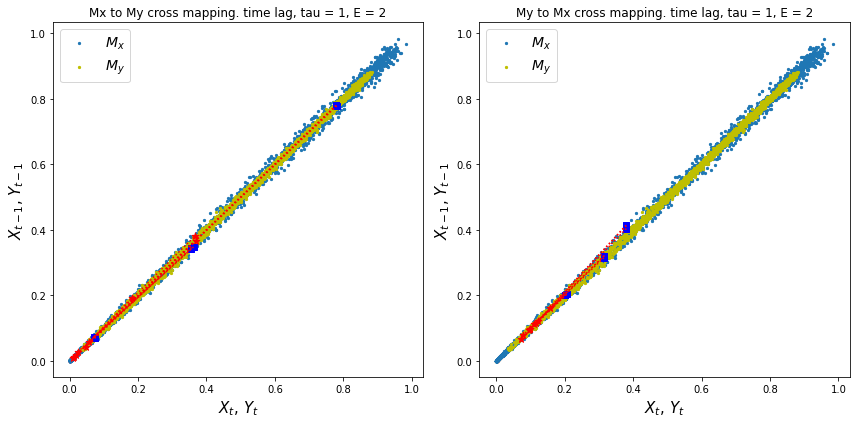

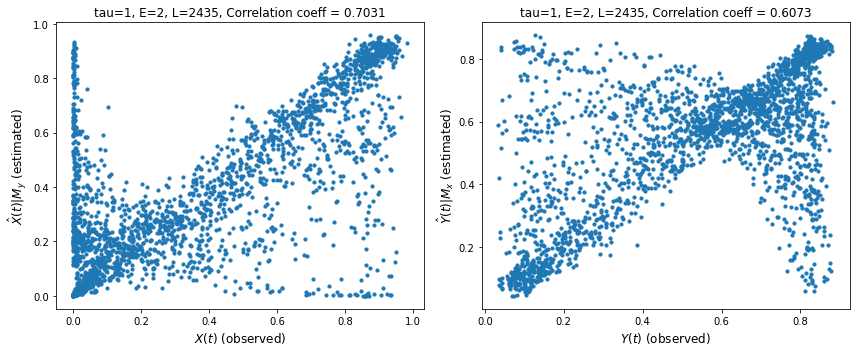

SW_down -> sea_ice_extent r 0.7 p value 0.0
sea_ice_extent -> SW_down r 0.61 p value 0.0


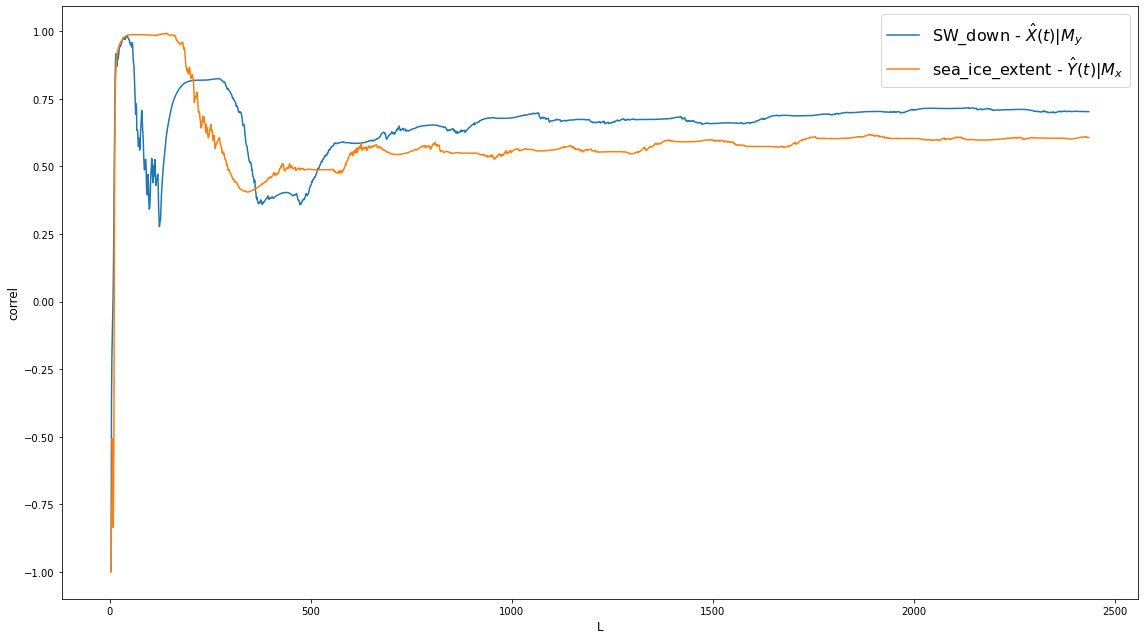

In [82]:
# Visualize simple shadow manifolds Mx and My for different tau
# We visualize Cross-Mapping

np.random.seed(1) # we fix the seed when randomly choosing cross mapping points
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = df.shape[0] # length of time period to consider

Y = df['sea_ice_extent'].values
X = df['SW_down'].values


ccm1 = ccm(X, Y, tau, E, L)

# causality X -> Y
# returns: (correlation ("strength" of causality), p-value(significance))
ccm1.causality()


# visualize sample cross mapping
ccm1.visualize_cross_mapping()

# Looking at "convergence"
L_range = range(3, L+1, 1) # L values to test
Xhat_My, Yhat_Mx = [], [] # correlation list
for L in L_range: 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0])    
    
# Check correlation plot
ccm1.plot_ccm_correls() 

# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(16,9))
plt.plot(L_range, Xhat_My, label='SW_down - $\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, label='sea_ice_extent - $\hat{Y}(t)|M_x$')
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 16})  

print('SW_down -> sea_ice_extent r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY.causality()[1], 2))
print('sea_ice_extent -> SW_down r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX.causality()[1], 2))

#### SST vs sea_ice_extent

In [83]:
df = df3[['sst', 'sea_ice_extent']]
df['date'] = df.index
make_plots(df, 'date', 'sst', 'sea_ice_extent')

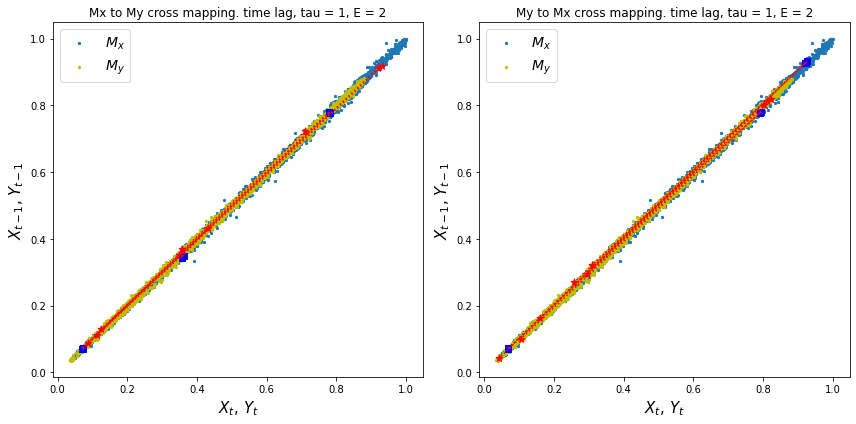

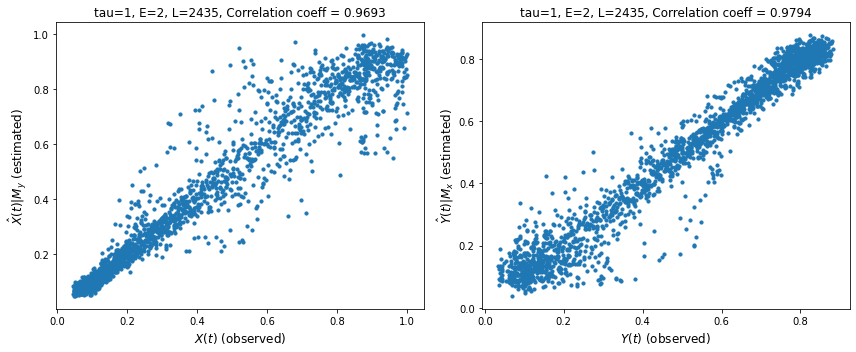

sst -> sea_ice_extent r 0.97 p value 0.0
sea_ice_extent -> sst r 0.98 p value 0.0


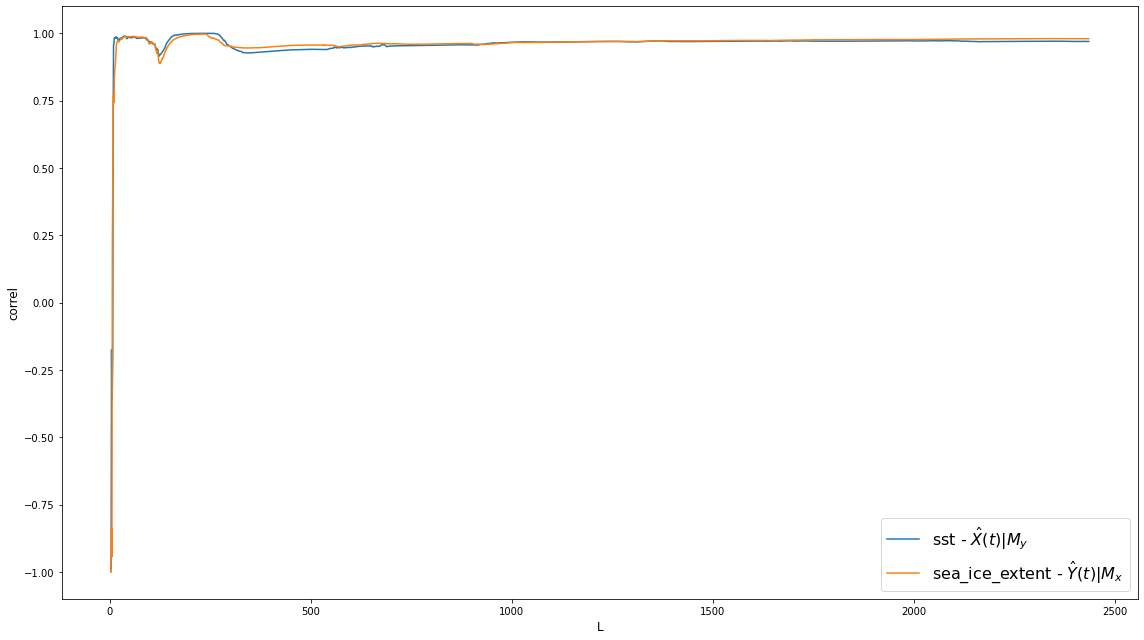

In [84]:
# Visualize simple shadow manifolds Mx and My for different tau
# We visualize Cross-Mapping

np.random.seed(1) # we fix the seed when randomly choosing cross mapping points
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = df.shape[0] # length of time period to consider

Y = df['sea_ice_extent'].values
X = df['sst'].values


ccm1 = ccm(X, Y, tau, E, L)

# causality X -> Y
# returns: (correlation ("strength" of causality), p-value(significance))
ccm1.causality()


# visualize sample cross mapping
ccm1.visualize_cross_mapping()

# Looking at "convergence"
L_range = range(3, L+1, 1) # L values to test
Xhat_My, Yhat_Mx = [], [] # correlation list
for L in L_range: 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0])    
    
# Check correlation plot
ccm1.plot_ccm_correls() 

# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(16,9))
plt.plot(L_range, Xhat_My, label='sst - $\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, label='sea_ice_extent - $\hat{Y}(t)|M_x$')
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 16})  

print('sst -> sea_ice_extent r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY.causality()[1], 2))
print('sea_ice_extent -> sst r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX.causality()[1], 2))